In [1]:
import pickle

import matplotlib.pyplot as plt
from matplotlib import collections as mc
import numpy as np
import sklearn
from sklearn import linear_model
import torch

from cvae.vae import VAE
from envs.panda_center_out import PandaCenterOutEnv

In [2]:
with open('data/demonstration_center_out.pkl', 'rb') as fp:
    episodes = pickle.load(fp)

In [3]:
env = PandaCenterOutEnv(render=False, control_type='ee')

In [4]:
# Enumerate the goals

goals = set()

while len(goals) != 8:
    obs = env.reset()
    goals.add(tuple(obs['desired_goal']))
    
goals = sorted(list(goals), key=lambda g: (-g[1], g[0]))

In [5]:
goals

[(-0.1115603298898189, 0.14999999999780553, 0.19740014349589585),
 (0.0384396701101811, 0.14999999999780553, 0.19740014349589585),
 (0.1884396701101811, 0.14999999999780553, 0.19740014349589585),
 (-0.1115603298898189, -2.194472194883551e-12, 0.19740014349589585),
 (0.1884396701101811, -2.194472194883551e-12, 0.19740014349589585),
 (-0.1115603298898189, -0.15000000000219446, 0.19740014349589585),
 (0.0384396701101811, -0.15000000000219446, 0.19740014349589585),
 (0.1884396701101811, -0.15000000000219446, 0.19740014349589585)]

In [6]:
neutral_ee_position = obs['achieved_goal']
neutral_joint_angles = np.array([env.robot.get_joint_angle(i) for i in range(10)])

In [7]:
# Enumerate the joint angles for each goal

joint_angles_at_goals = []

for goal in goals:
    while tuple(env._get_obs()['desired_goal']) != goal:
        obs = env.reset()
    
    is_success = False
    while not is_success:
        a = obs['desired_goal'] - obs['achieved_goal']
        obs, _, _, info = env.step(a)
        is_success = info['is_success']
        
    joint_angles = np.array([env.robot.get_joint_angle(i) for i in range(10)])
    joint_angles_at_goals.append(joint_angles)

In [8]:
joint_angles_at_goals

[array([ 1.44588306e-01,  1.56268346e-01,  8.07866432e-02, -2.22773083e+00,
        -1.82527290e-02,  2.38333390e+00,  1.02300393e+00,  0.00000000e+00,
         0.00000000e+00,  4.39487283e-08]),
 array([ 1.19207576e-01,  4.28402138e-01,  4.35761332e-02, -1.82187401e+00,
        -2.32348485e-02,  2.24982594e+00,  9.58834546e-01,  0.00000000e+00,
         0.00000000e+00,  8.57329017e-08]),
 array([ 1.52117856e-01,  7.97187831e-01,  3.49613257e-02, -1.21386862e+00,
        -2.76501959e-02,  2.01099579e+00,  9.73732990e-01,  0.00000000e+00,
         0.00000000e+00,  5.43568914e-07]),
 array([-7.52278690e-04,  1.41666620e-01,  7.54507637e-04, -2.24740225e+00,
        -1.59707497e-04,  2.38893706e+00,  7.85508406e-01,  0.00000000e+00,
         0.00000000e+00, -4.83577737e-07]),
 array([-4.32464727e-04,  7.34278866e-01,  4.17566266e-04, -1.32124125e+00,
        -3.23125398e-04,  2.05588736e+00,  7.85434240e-01,  0.00000000e+00,
         0.00000000e+00,  1.29650770e-07]),
 array([-1.46284674e

/Users/qinyilong/Local Desktop/7dof_env/lib/python3.6/site-packages/panda_gym/pybullet.py:102: UserWarning: The use of the render method is not recommended when the environment has not been created with render=True. The rendering will probably be weird. Prefer making the environment with option `render=True`. For example: `env = gym.make('PandaReach-v2', render=True)`.
  UserWarning,


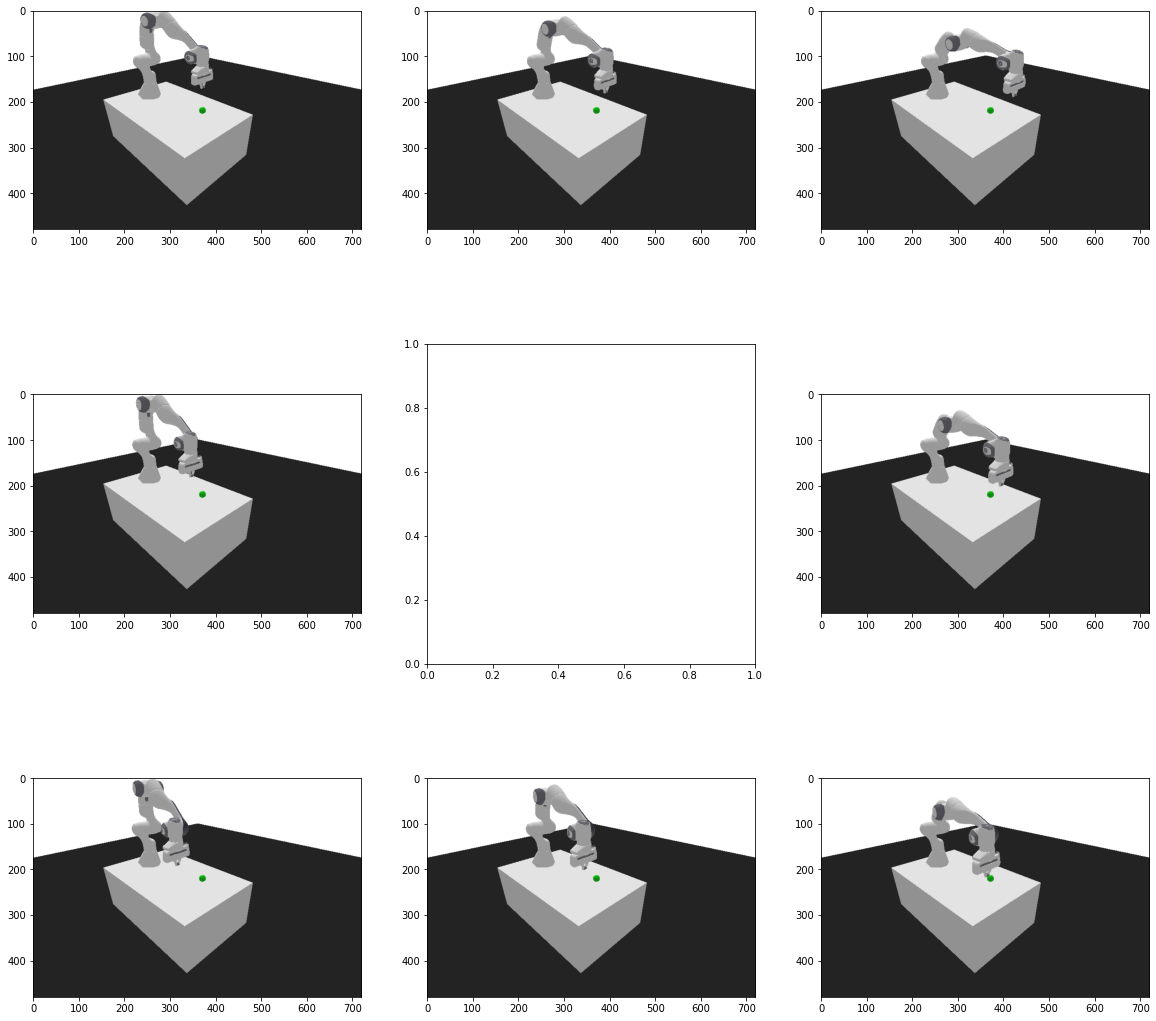

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, joint_angles in enumerate(joint_angles_at_goals):
    if i >= 4:
        i += 1 # offset for visualization
    
    env.robot.set_joint_angles(joint_angles)
    rgb_array = env.render('rgb_array')
    axs[i // 3, i % 3].imshow(rgb_array)

In [10]:
actions_joints = np.array([step['action_joints'] for epi in episodes for step in epi])

In [11]:
env = PandaCenterOutEnv(render=False, control_type='joints')

## Random initialization

In [12]:
decoder = VAE(action_dim=7, latent_dim=2, enc_dims=(2, ), dec_dims=(), lr=0, kl_coeff=0)

In [13]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

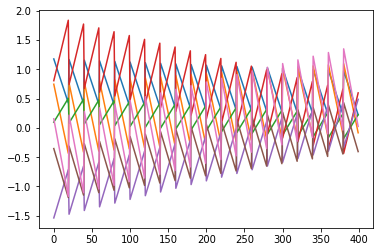

In [14]:
for i in range(7):
    plt.plot(actions_joints[:, i])

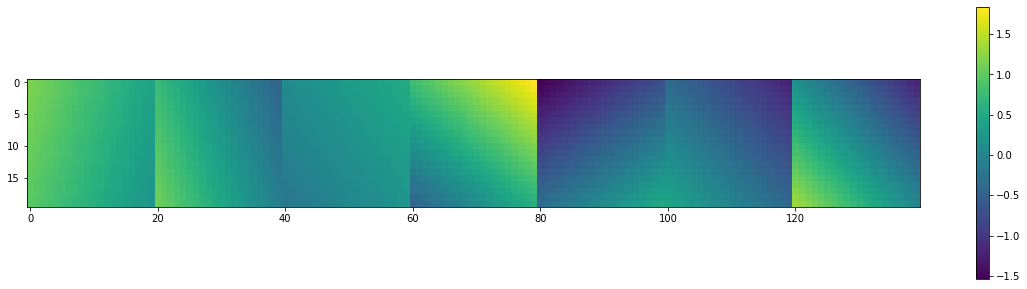

In [15]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [16]:
for param in decoder.decoder.named_parameters():
    print(param)

('0.weight', Parameter containing:
tensor([[-0.3948, -0.1067],
        [-0.6202,  0.1840],
        [ 0.2139, -0.1463],
        [ 0.5434, -0.6530],
        [ 0.4331,  0.6326],
        [-0.4399,  0.4126],
        [-0.6973,  0.6287]], requires_grad=True))
('0.bias', Parameter containing:
tensor([ 0.6753,  0.3087,  0.1649,  0.6955, -0.4723, -0.3811,  0.0860],
       requires_grad=True))


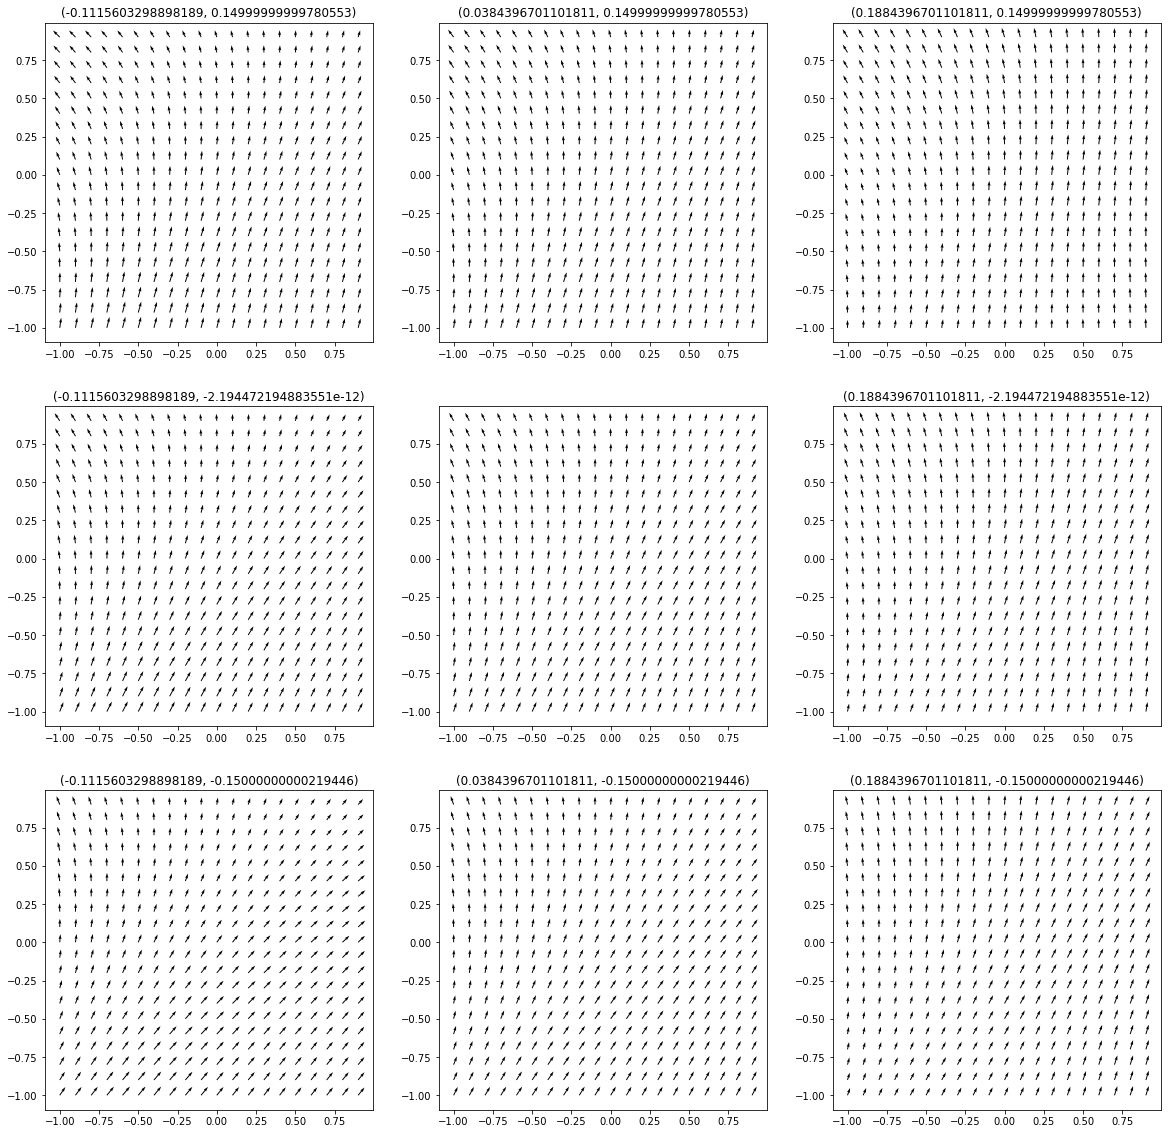

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

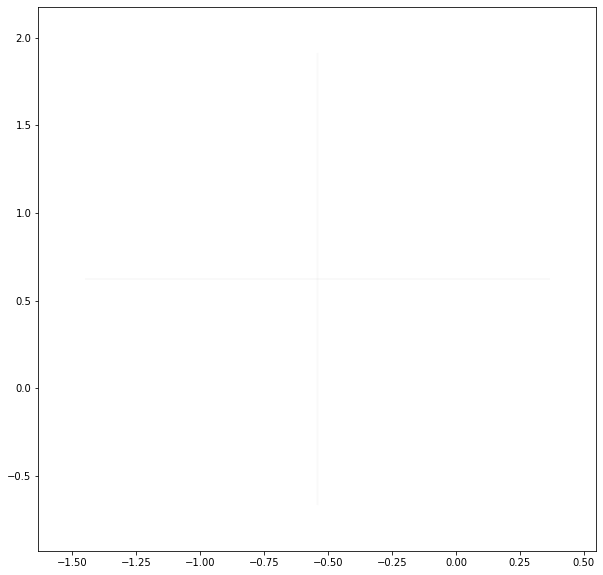

In [18]:
actions_joints_test = np.array([step['action_joints'] for epi in episodes for step in epi])[100000:101000]

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)
plt.show()

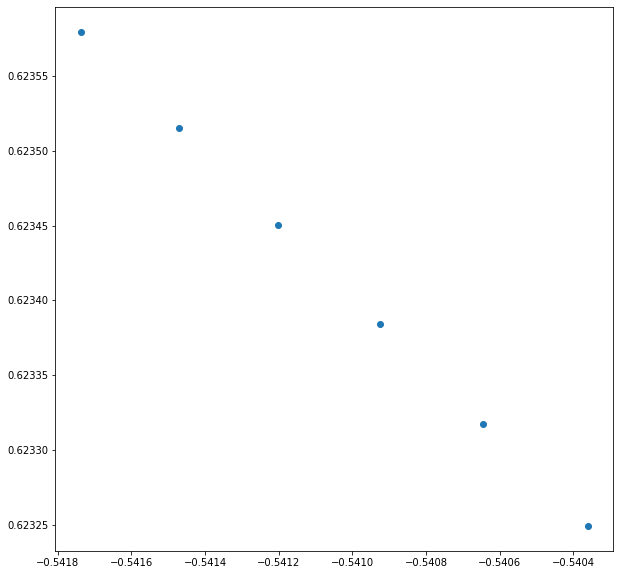

In [19]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

## smooth-tree-399
small model, full radius

In [20]:
decoder = VAE.load_from_checkpoint('latent-action/1vomcwla/checkpoints/epoch=399-step=999999.ckpt')

In [21]:
decoder

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU()
    (2): Linear(in_features=3, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
)

In [22]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

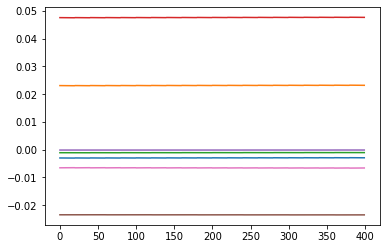

In [23]:
for i in range(7):
    plt.plot(actions_joints[:, i])

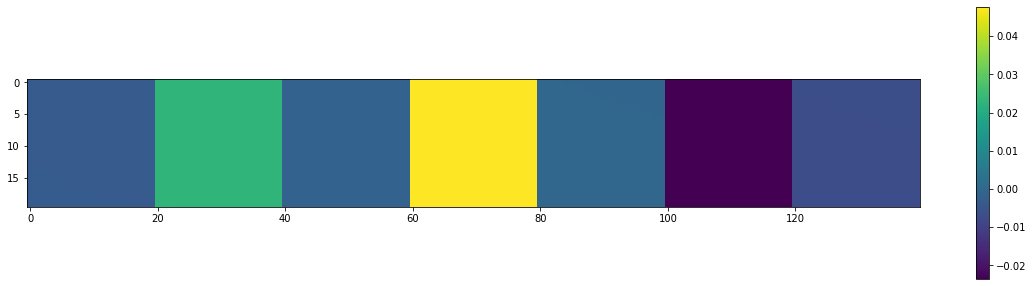

In [24]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [25]:
actions_joints.mean(axis=0)

array([-0.00297557,  0.02309987, -0.00109876,  0.0475655 , -0.00015316,
       -0.0234826 , -0.00658052], dtype=float32)

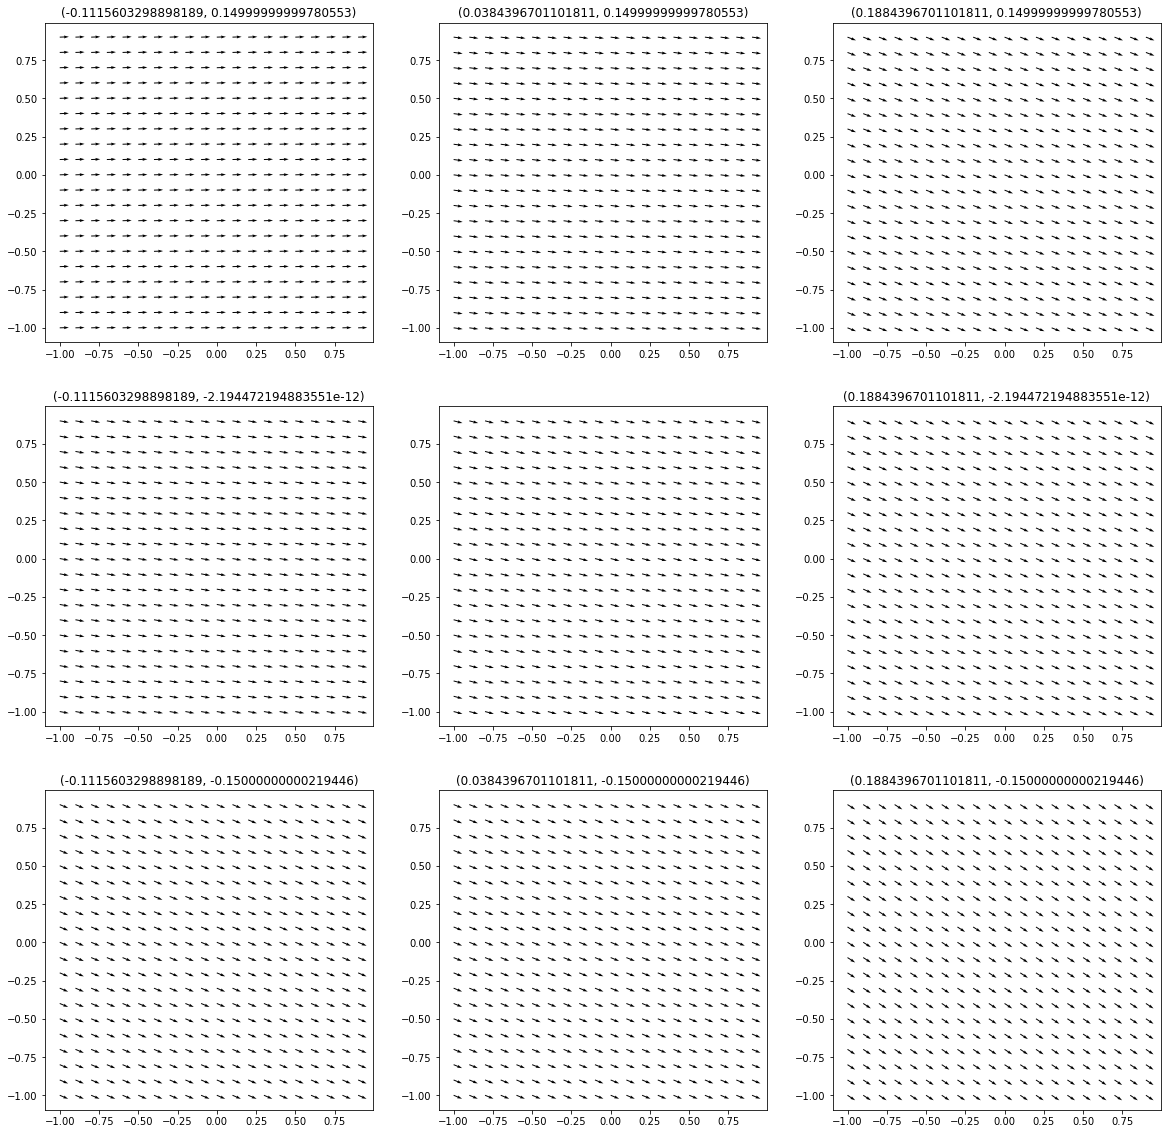

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

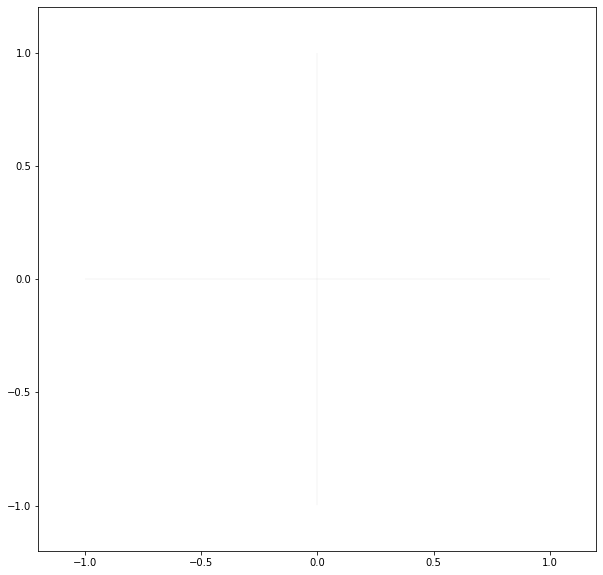

In [27]:
actions_joints_test = np.array([step['action_joints'] for epi in episodes for step in epi])[100000:101000]

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

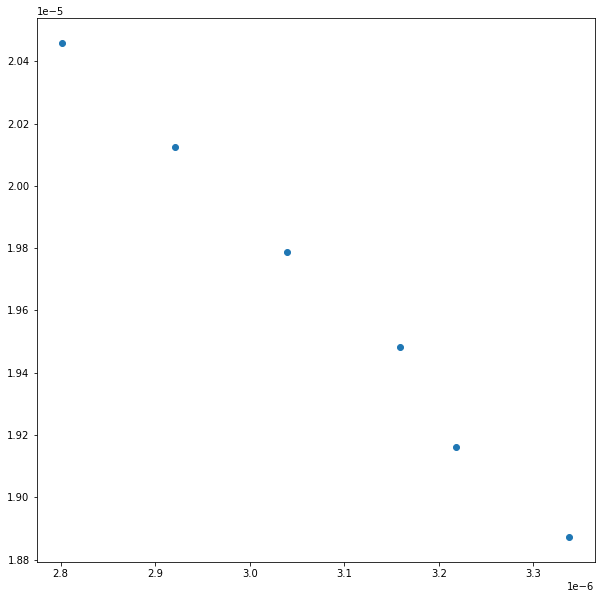

In [28]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

## fearless-fog-400
big model, full radius

In [29]:
decoder = VAE.load_from_checkpoint('latent-action/1873e075/checkpoints/epoch=399-step=999999.ckpt')

In [30]:
decoder

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=10, out_features=2, bias=True)
  (fc_var): Linear(in_features=10, out_features=2, bias=True)
)

In [31]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

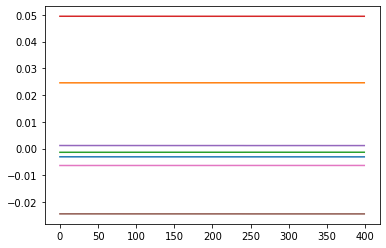

In [32]:
for i in range(7):
    plt.plot(actions_joints[:, i])

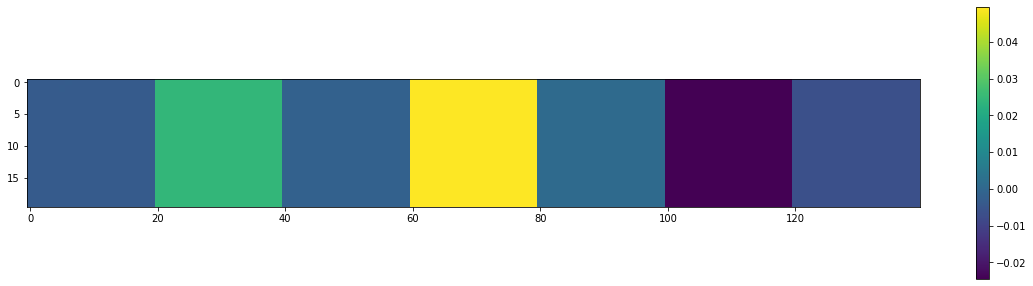

In [33]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [34]:
actions_joints.mean(axis=0)

array([-0.00310208,  0.02458497, -0.00138745,  0.04945556,  0.00112026,
       -0.02443394, -0.00632739], dtype=float32)

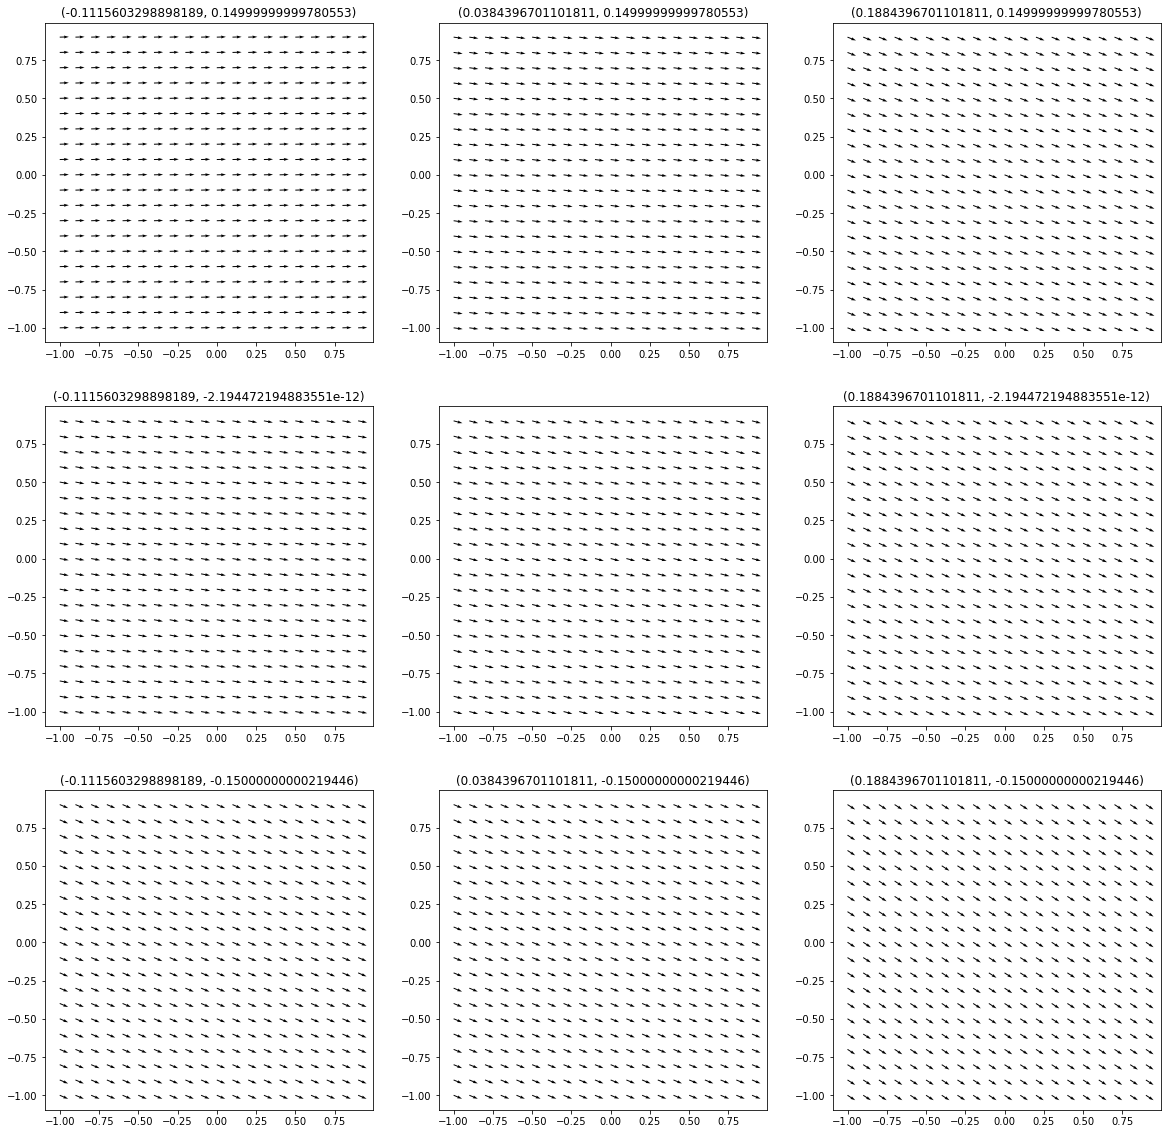

In [35]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

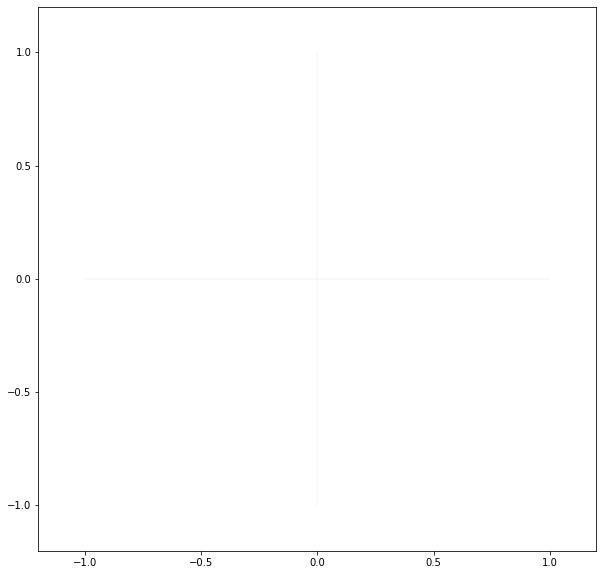

In [36]:
actions_joints_test = np.array([step['action_joints'] for epi in episodes for step in epi])[100000:101000]

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

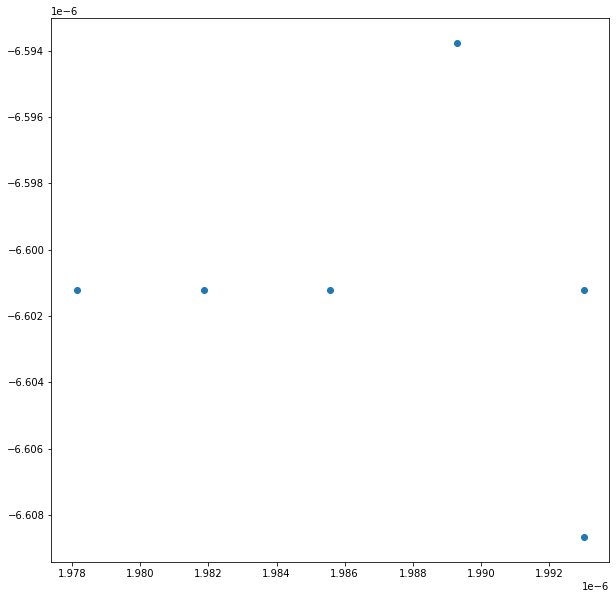

In [37]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

## bright-surf-401
big model, half radius

In [38]:
decoder = VAE.load_from_checkpoint('latent-action/37cgy8fq/checkpoints/epoch=399-step=999999.ckpt')

In [39]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

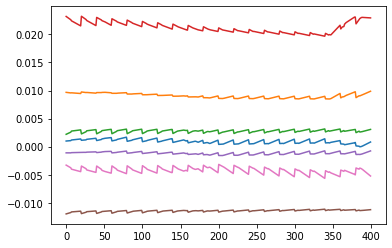

In [40]:
for i in range(7):
    plt.plot(actions_joints[:, i])

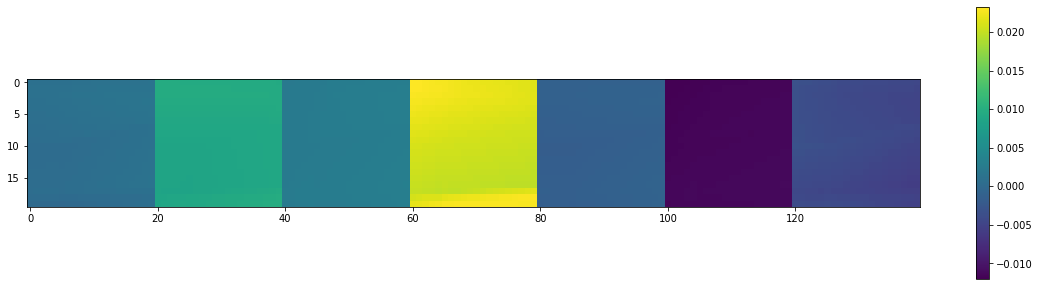

In [41]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [42]:
actions_joints.mean(axis=0)

array([ 0.00094016,  0.00906211,  0.00278589,  0.02125011, -0.00115633,
       -0.01143865, -0.00426206], dtype=float32)

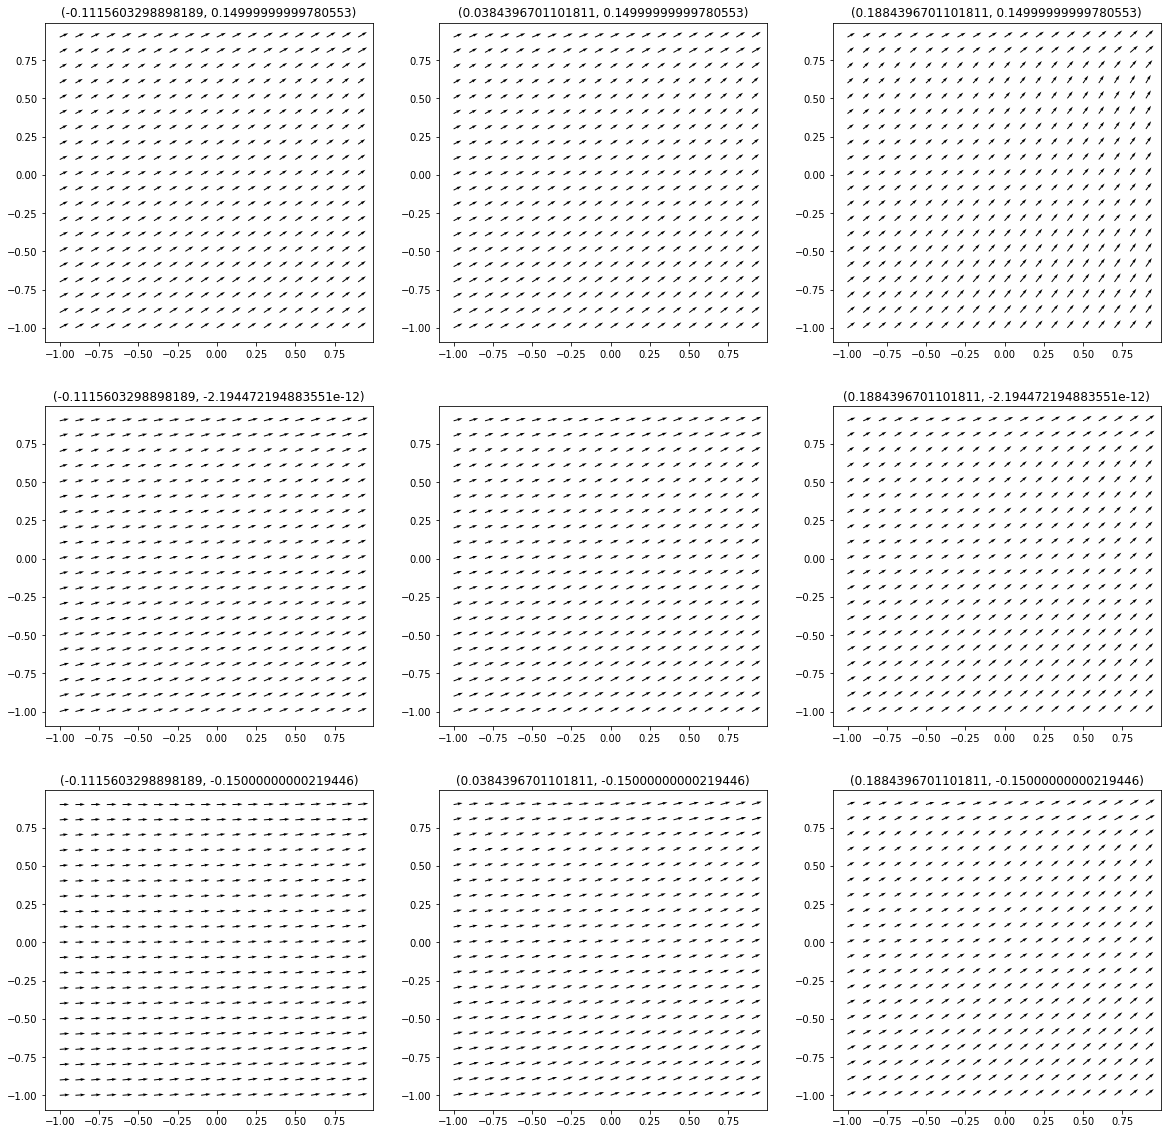

In [43]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

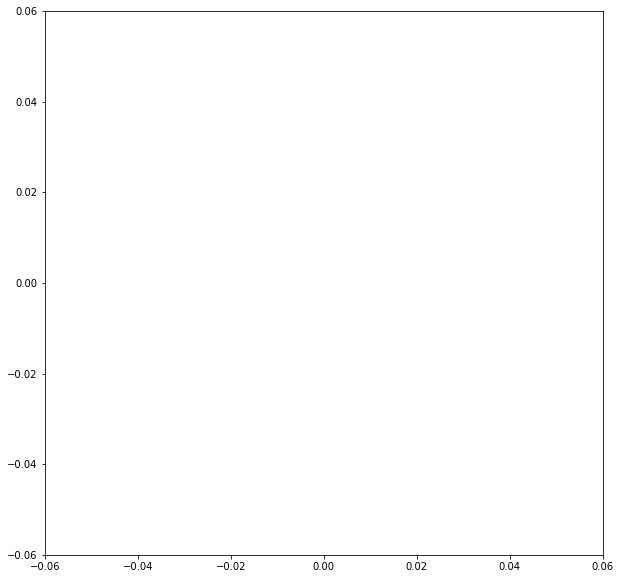

In [44]:
actions_joints_test = np.array([step['action_joints'] for epi in episodes for step in epi if step['radius'] < 0.06])[100000:101000]

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

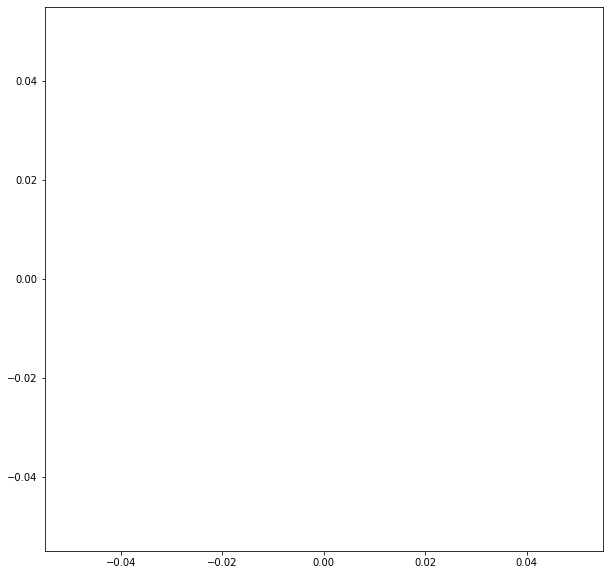

In [45]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

## twilight-surf-402
big model, quarter radius

In [46]:
decoder = VAE.load_from_checkpoint('latent-action/3ivanabl/checkpoints/epoch=399-step=999999.ckpt')

In [47]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

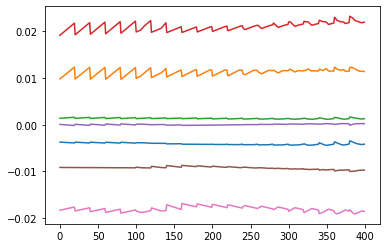

In [48]:
for i in range(7):
    plt.plot(actions_joints[:, i])

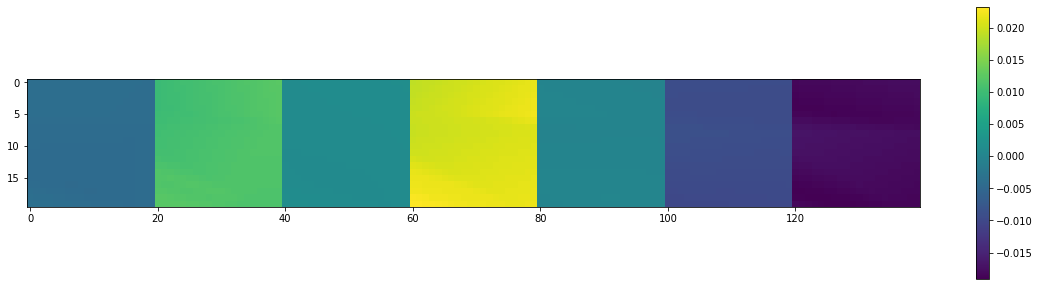

In [49]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [50]:
actions_joints.mean(axis=0)

array([-4.0747300e-03,  1.1267171e-02,  1.3626739e-03,  2.1021940e-02,
        5.5558885e-05, -9.2505161e-03, -1.8031666e-02], dtype=float32)

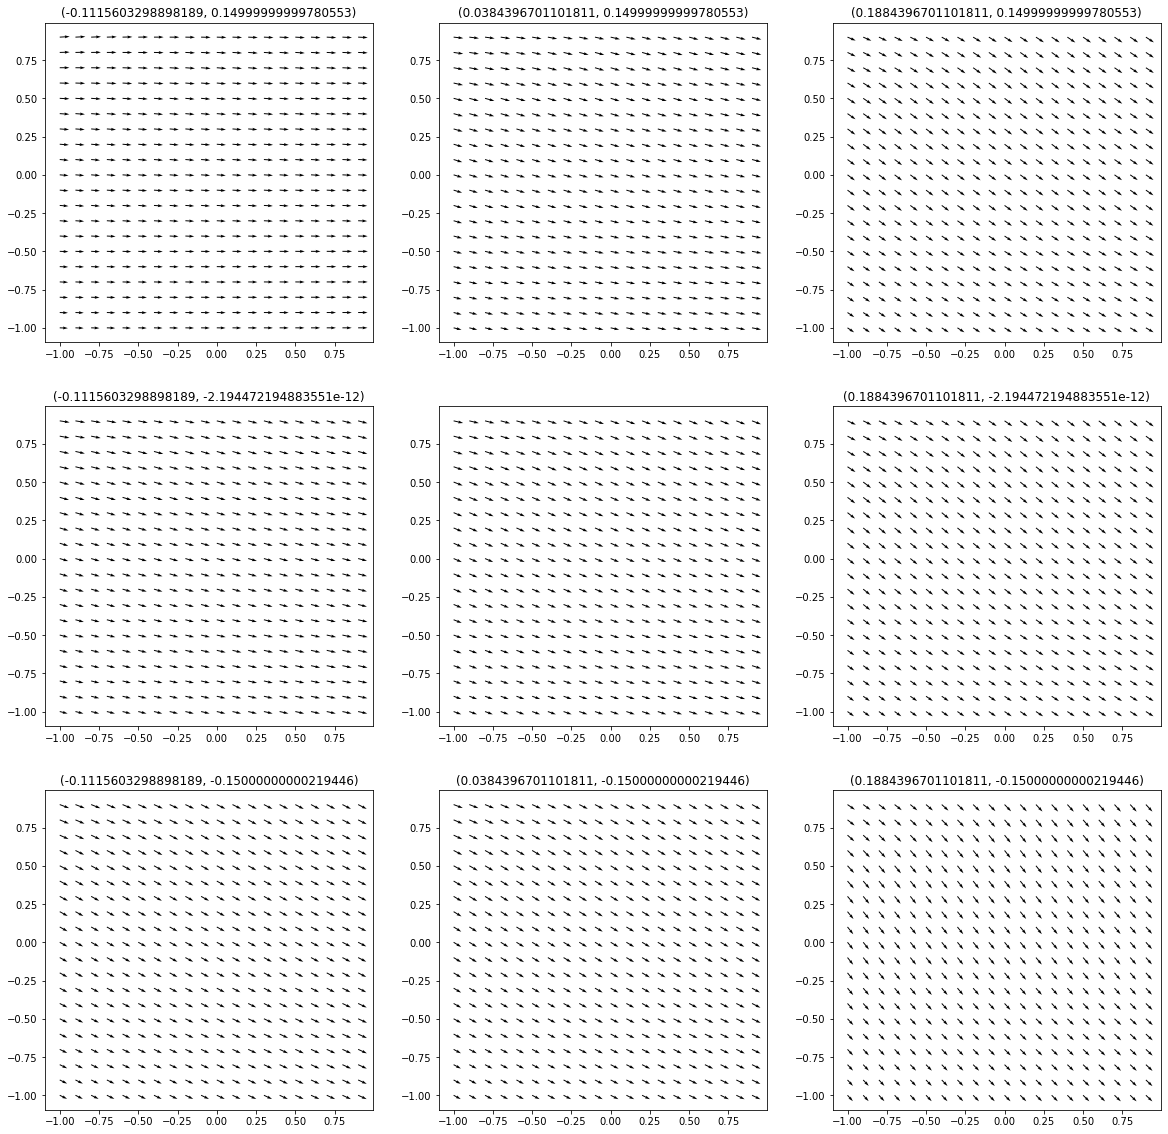

In [51]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

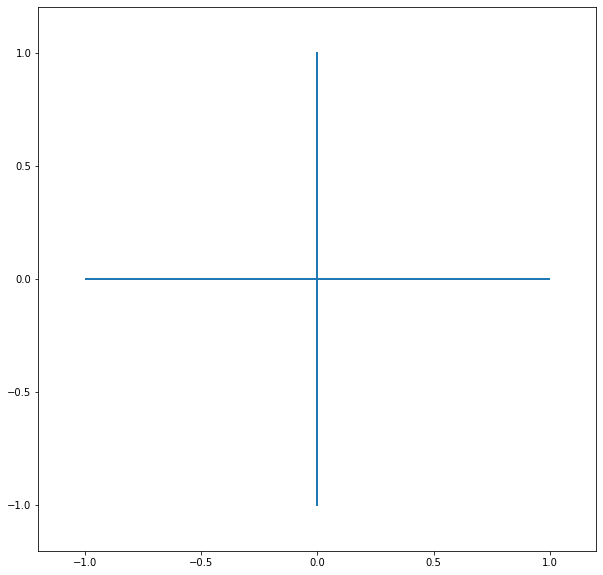

In [52]:
actions_joints = np.array([step['action_joints'] for epi in episodes for step in epi if step['radius'] < 0.03])
actions_joints_train = actions_joints[:100000]

x = decoder.encoder(torch.tensor(actions_joints_train, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

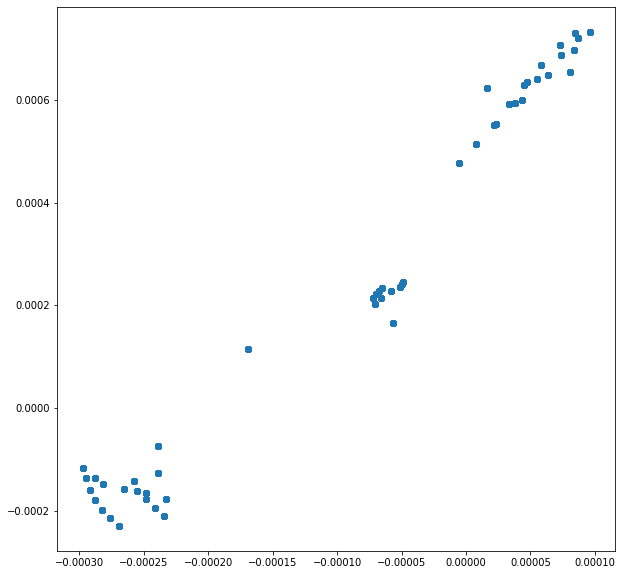

In [53]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

## devoted-plant-403
small model, quarter radius

In [54]:
decoder = VAE.load_from_checkpoint('latent-action/1bsmsneu/checkpoints/epoch=399-step=999999.ckpt')

In [55]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

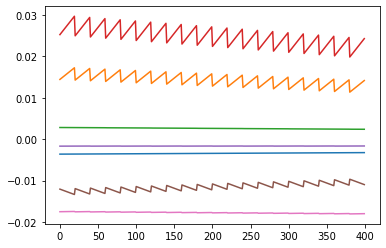

In [56]:
for i in range(7):
    plt.plot(actions_joints[:, i])

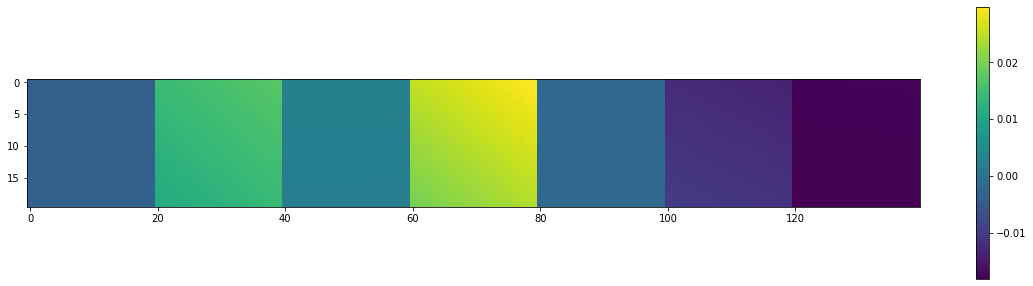

In [57]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [58]:
actions_joints.mean(axis=0)

array([-0.00343556,  0.01431457,  0.00260765,  0.02479776, -0.00166767,
       -0.01153329, -0.01777948], dtype=float32)

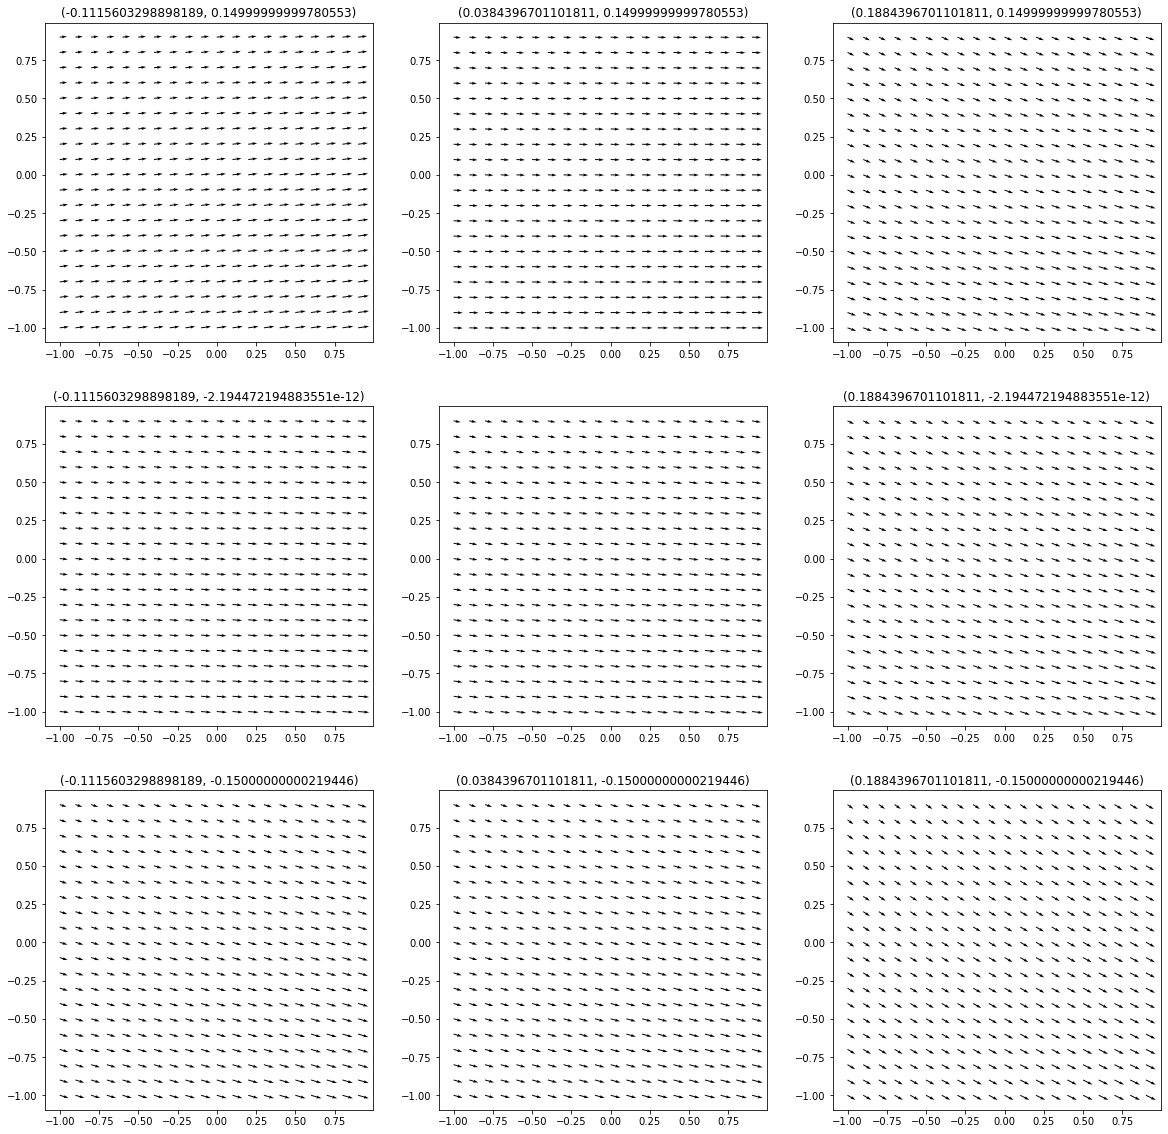

In [59]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

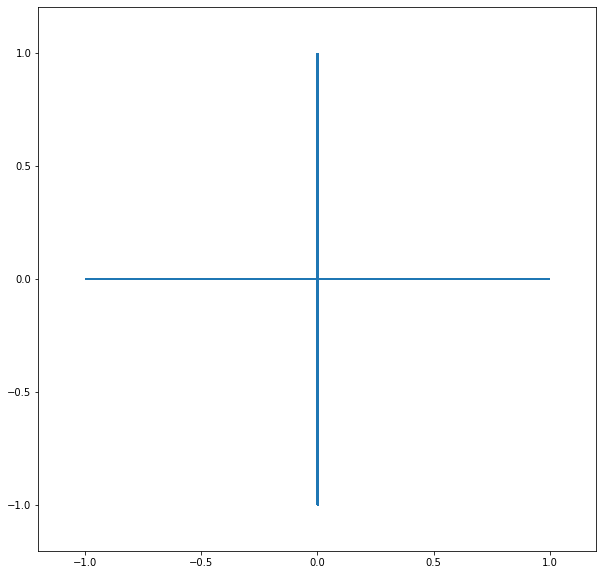

In [60]:
actions_joints = np.array([step['action_joints'] for epi in episodes for step in epi if step['radius'] < 0.03])
actions_joints_train = actions_joints[:100000]

x = decoder.encoder(torch.tensor(actions_joints_train, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

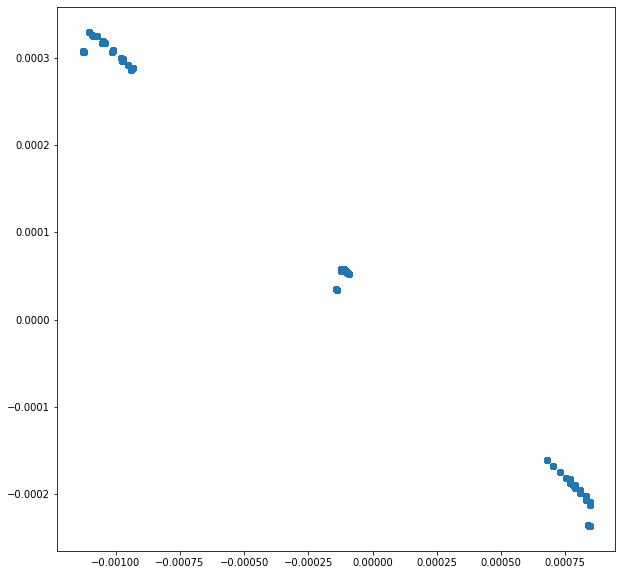

In [61]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

## lemon-haze-404
small model, half radius

In [62]:
decoder = VAE.load_from_checkpoint('latent-action/3sf9tiju/checkpoints/epoch=399-step=999999.ckpt')

In [63]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

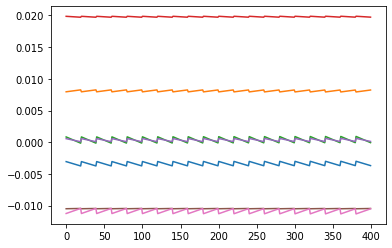

In [64]:
for i in range(7):
    plt.plot(actions_joints[:, i])

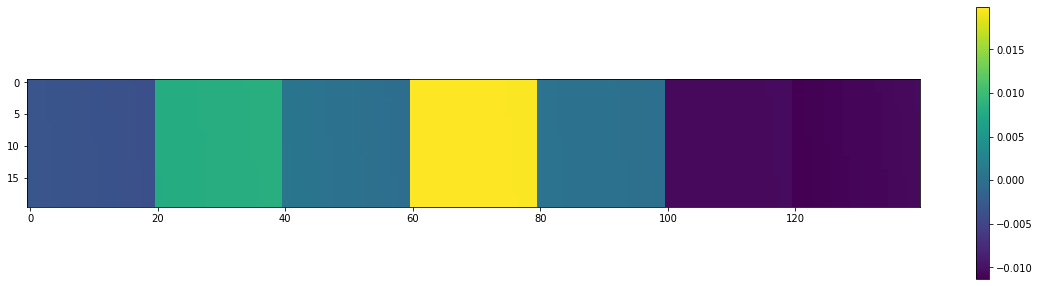

In [65]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [66]:
actions_joints.mean(axis=0)

array([-0.00337357,  0.00809585,  0.00038384,  0.01979752,  0.00034392,
       -0.01047308, -0.01087594], dtype=float32)

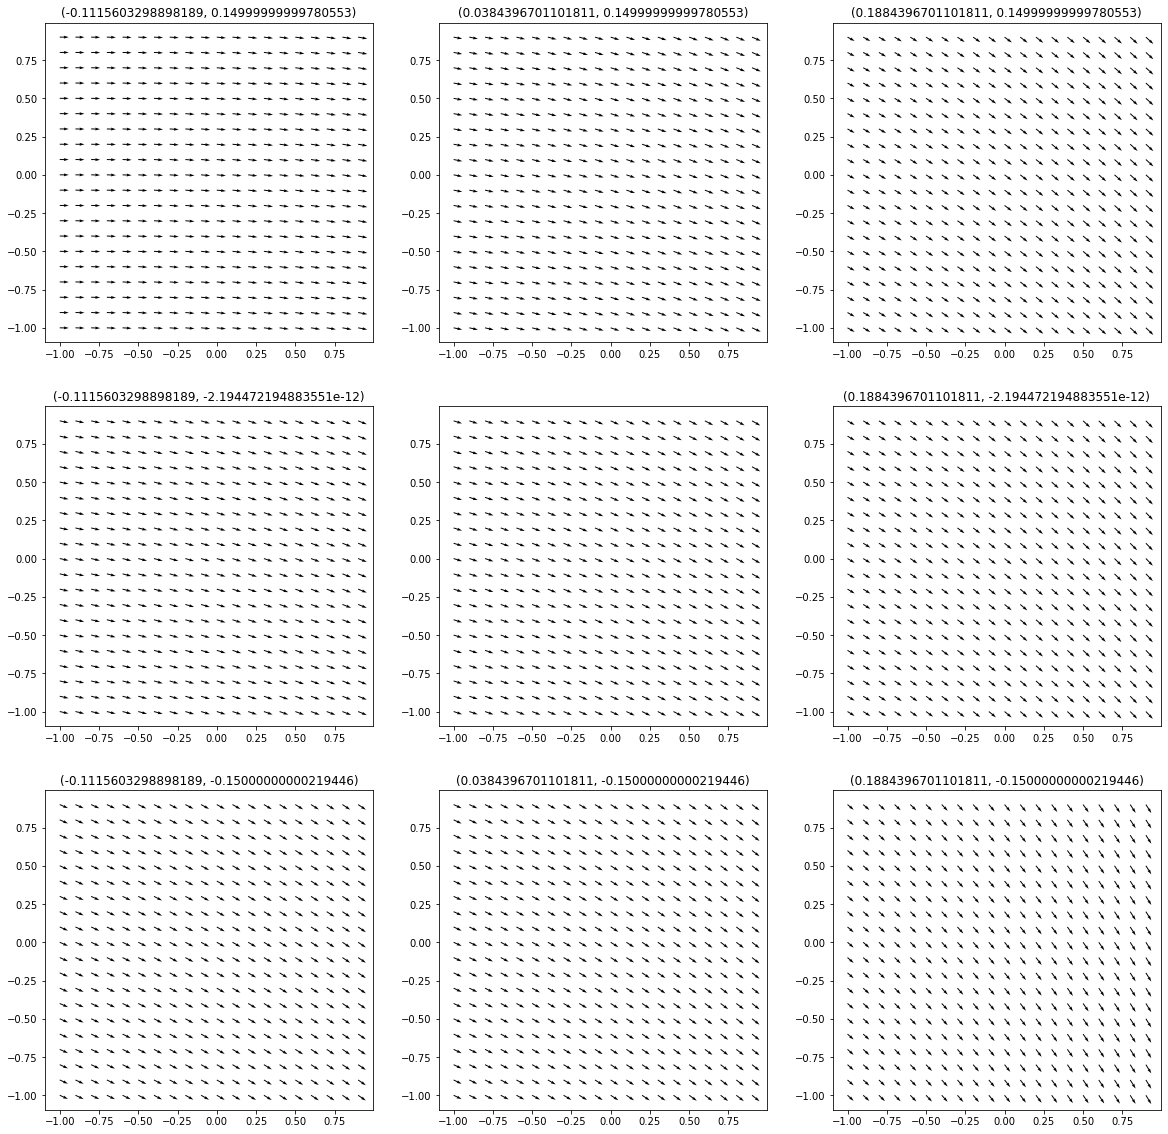

In [67]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

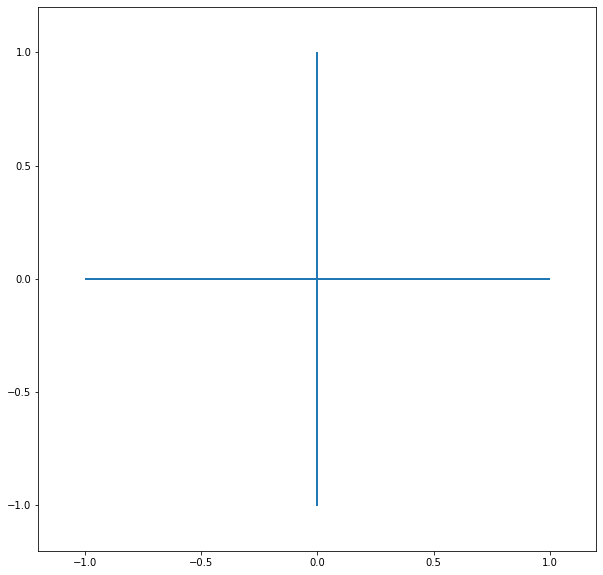

In [68]:
actions_joints = np.array([step['action_joints'] for epi in episodes for step in epi if step['radius'] < 0.06])
actions_joints_train = actions_joints[:100000]

x = decoder.encoder(torch.tensor(actions_joints_train, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

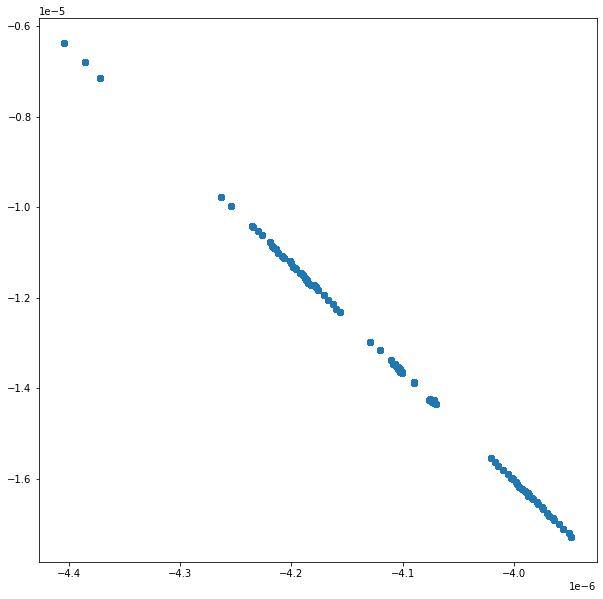

In [69]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

## stellar-smoke-405
KL coeff = 0, full radius

In [70]:
decoder = VAE.load_from_checkpoint('latent-action/24fi7xx7/checkpoints/epoch=399-step=999999.ckpt')

In [71]:
x, y = np.meshgrid(np.arange(0, 8, 0.2), np.arange(-5, 1, 0.2))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

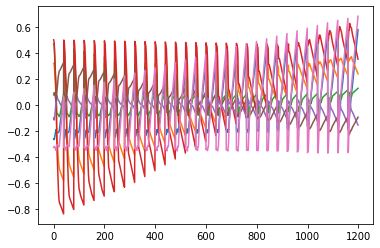

In [72]:
for i in range(7):
    plt.plot(actions_joints[:, i])

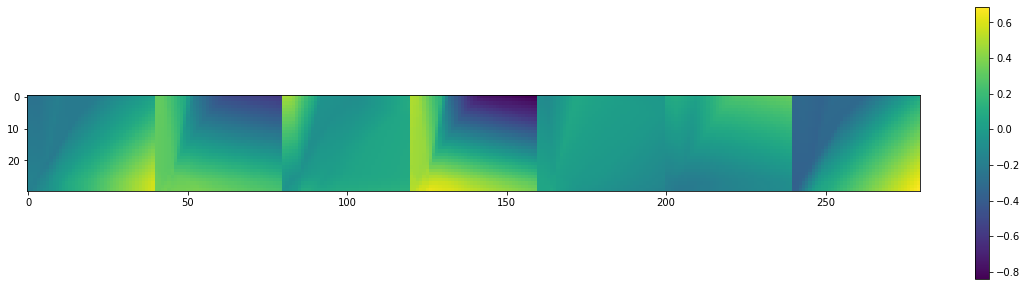

In [73]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(30, 40) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [74]:
actions_joints.mean(axis=0)

array([ 0.012917  ,  0.01067209,  0.04304617,  0.02011987, -0.01539223,
        0.01365798, -0.00809315], dtype=float32)

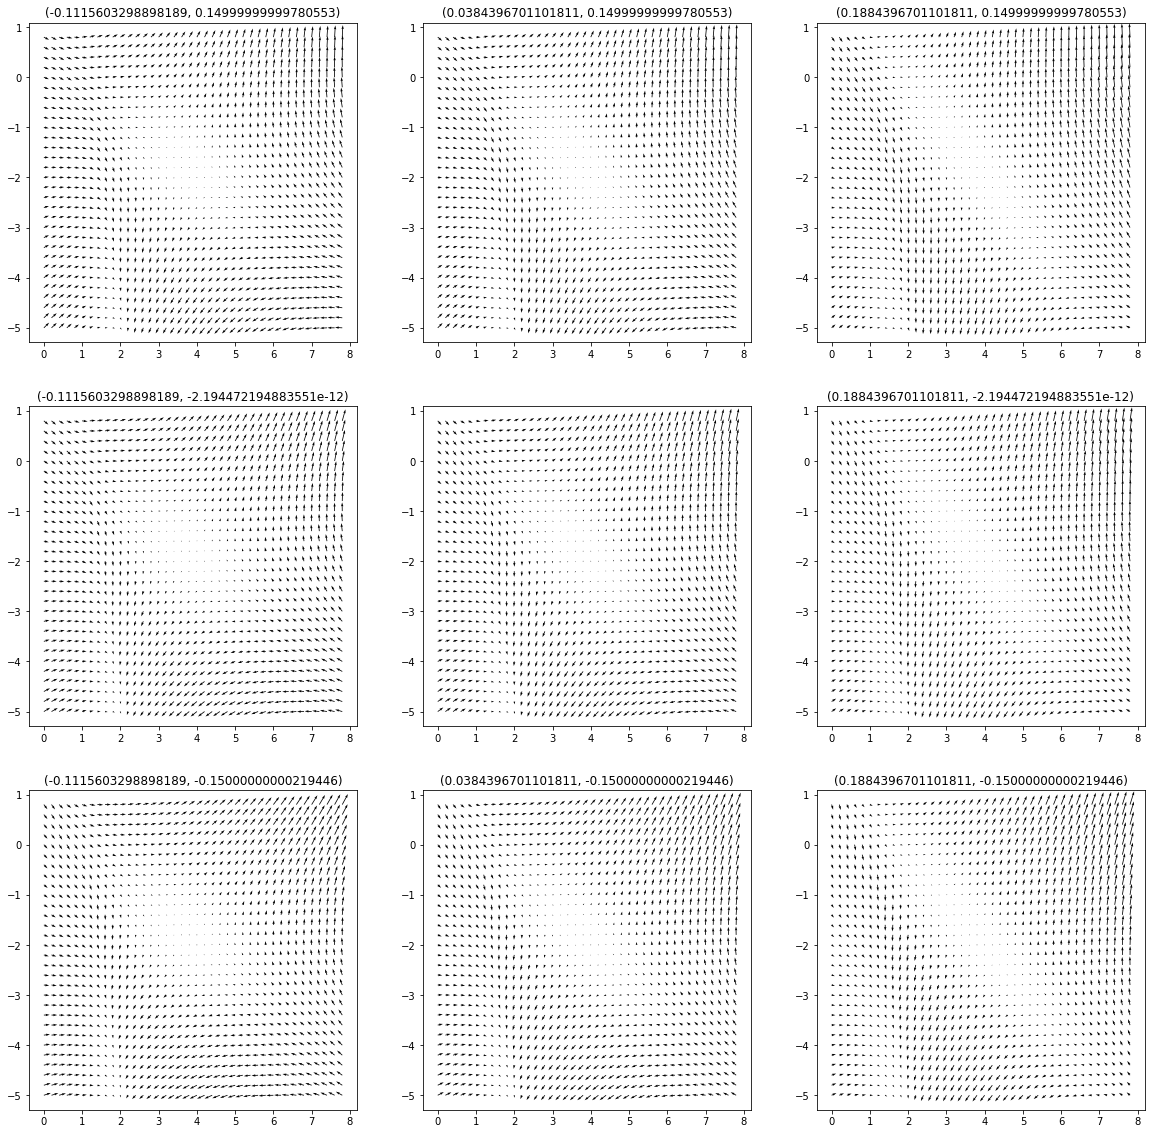

In [75]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

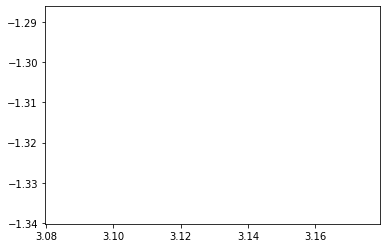

In [76]:
actions_joints_test = np.array([step['action_joints'] for epi in episodes for step in epi])[100000:101000]

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots()
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

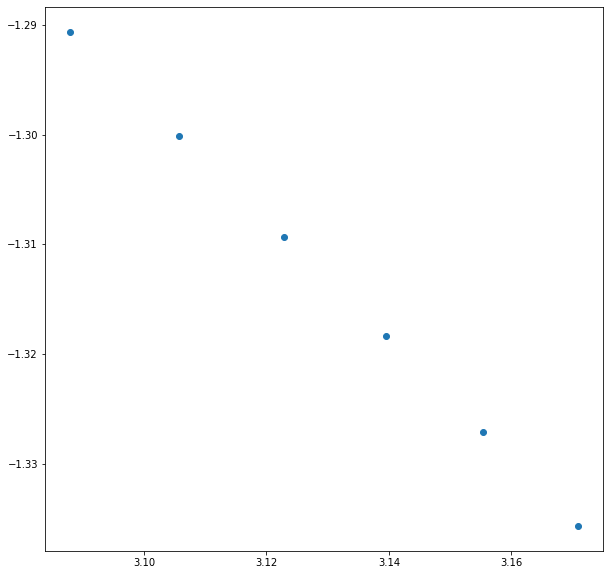

In [77]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

In [78]:
env = PandaCenterOutEnv(render=False, control_type='joints')
env.reset()

{'observation': array([ 3.84396701e-02, -2.19447219e-12,  1.97400143e-01,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00]),
 'achieved_goal': array([ 3.84396701e-02, -2.19447219e-12,  1.97400143e-01]),
 'desired_goal': array([ 0.03843967, -0.15      ,  0.19740014])}

In [79]:
def ee_displacement_to_arm_joint_ctrl(env_ee, action_ee):
    action_clipped = np.clip(action_ee, np.array([-1]*3), np.array([1]*3))   
    ee_displacement = action_clipped[:3]
    target_arm_angles = env_ee.robot.ee_displacement_to_target_arm_angles(
            ee_displacement)
    current_arm_joint_angles = np.array([
        env_ee.robot.get_joint_angle(joint=i) for i in range(7)])
    arm_joint_ctrl = target_arm_angles - current_arm_joint_angles
    return arm_joint_ctrl * 20

positions = []
actions_planned = []
actions_executed = []

for _ in range(10000):
    current_position = obs['achieved_goal']

    action_ee_planned = obs['desired_goal'] - current_position
    action_joint_planned = ee_displacement_to_arm_joint_ctrl(env, action_ee_planned)

    x = decoder.encoder(torch.tensor(action_joint_planned, dtype=torch.float))
    mu = decoder.fc_mu(x)
    action_joint_executed = decoder(context=None, latent=mu)

    obs, _, _, info = env.step(action_joint_executed.detach().numpy())
    action_ee_executed = obs['achieved_goal'] - current_position
    
    positions.append(current_position[:2])
    actions_planned.append(action_ee_planned[:2])
    actions_executed.append(action_ee_executed[:2])
    
positions = np.array(positions)
actions_planned = np.array(actions_planned)
actions_executed = np.array(actions_executed)

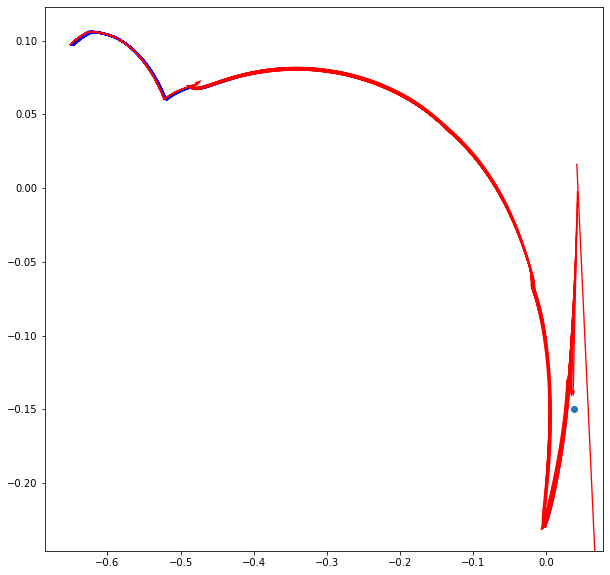

In [80]:
i = 9940
fig = plt.figure(figsize=(10, 10))
plt.quiver(positions[:i, 0], positions[:i, 1], actions_planned[:i, 0], actions_planned[:i, 1], color='b')
plt.quiver(positions[:i, 0], positions[:i, 1], actions_executed[:i, 0], actions_executed[:i, 1], color='r')
goal = env._get_obs()['desired_goal']
plt.scatter(goal[0], goal[1])
plt.show()

## Linear Regression

In [81]:
actions_joints = np.array([step['action_joints'] for epi in episodes for step in epi])
actions_ee = np.array([step['action_ee'] for epi in episodes for step in epi])

actions_joints_train = actions_joints[:100000]
actions_ee_train = actions_ee[:100000, :2]

In [82]:
decoder = linear_model.LinearRegression()

In [83]:
decoder.fit(actions_ee_train, actions_joints_train)

LinearRegression()

In [84]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = np.array(list(zip(x.reshape(-1), y.reshape(-1))))
actions_joints = decoder.predict(latents)

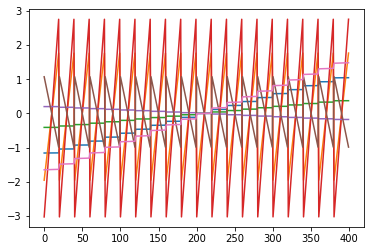

In [85]:
for i in range(7):
    plt.plot(actions_joints[:, i])

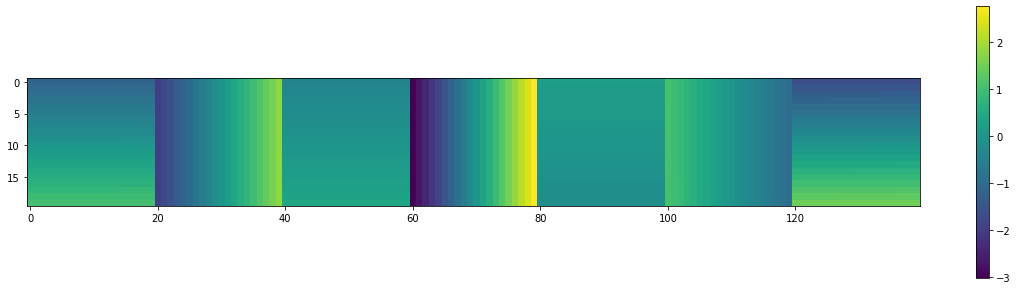

In [86]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

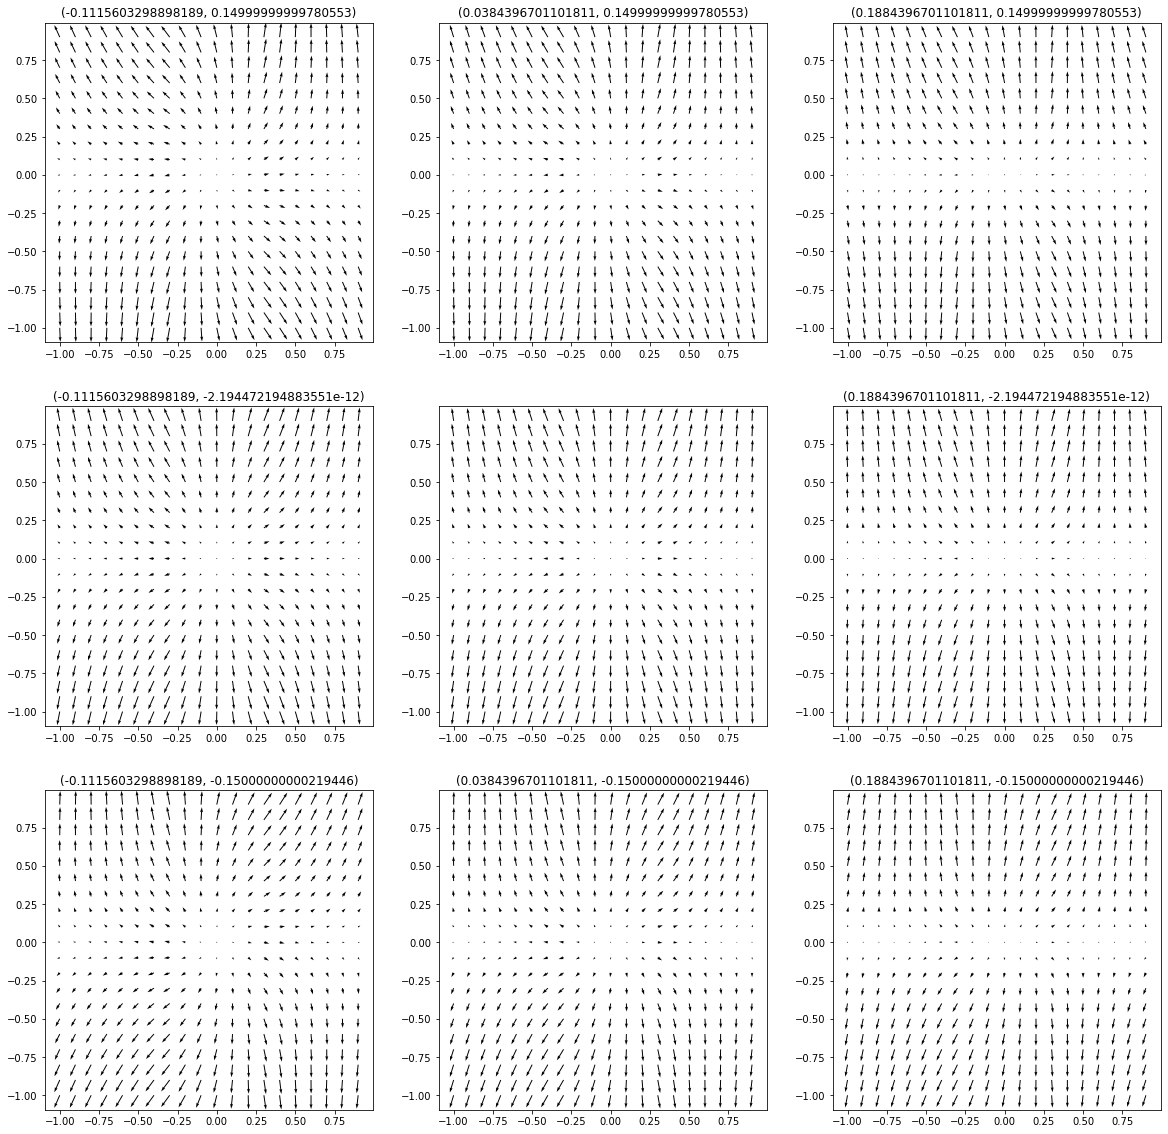

In [87]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

In [88]:
env = PandaCenterOutEnv(render=False, control_type='joints')
env.reset()

{'observation': array([ 3.84396701e-02, -2.19447219e-12,  1.97400143e-01,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00]),
 'achieved_goal': array([ 3.84396701e-02, -2.19447219e-12,  1.97400143e-01]),
 'desired_goal': array([ 1.88439670e-01, -2.19447219e-12,  1.97400143e-01])}

In [89]:
def ee_displacement_to_arm_joint_ctrl(env_ee, action_ee):
    action_clipped = np.clip(action_ee, np.array([-1]*3), np.array([1]*3))   
    ee_displacement = action_clipped[:3]
    target_arm_angles = env_ee.robot.ee_displacement_to_target_arm_angles(
            ee_displacement)
    current_arm_joint_angles = np.array([
        env_ee.robot.get_joint_angle(joint=i) for i in range(7)])
    arm_joint_ctrl = target_arm_angles - current_arm_joint_angles
    return arm_joint_ctrl * 20

positions = []
actions_planned = []
actions_executed = []

for _ in range(10000):
    current_position = obs['achieved_goal']

    action_ee_planned = obs['desired_goal'] - current_position
    action_joint_executed = decoder.predict(action_ee_planned[np.newaxis, :2])

    obs, _, _, info = env.step(action_joint_executed.squeeze())
    action_ee_executed = obs['achieved_goal'] - current_position
    
    positions.append(current_position[:2])
    actions_planned.append(action_ee_planned[:2])
    actions_executed.append(action_ee_executed[:2])
    
positions = np.array(positions)
actions_planned = np.array(actions_planned)
actions_executed = np.array(actions_executed)

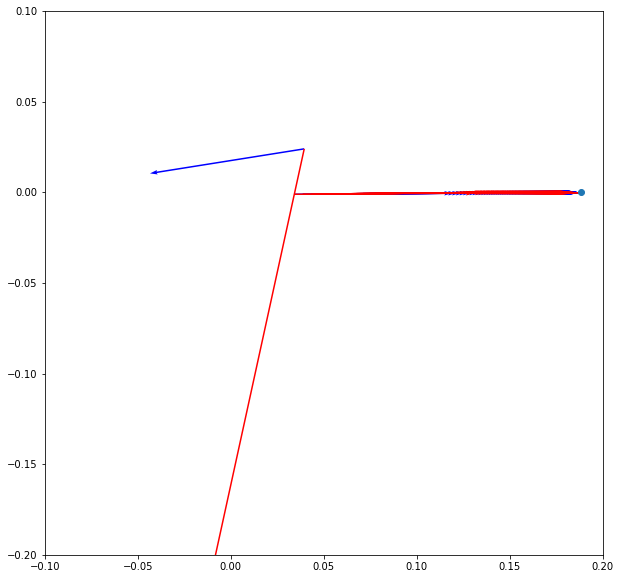

In [90]:
i = 500
fig = plt.figure(figsize=(10, 10))
plt.quiver(positions[:i, 0], positions[:i, 1], actions_planned[:i, 0], actions_planned[:i, 1], color='b')
plt.quiver(positions[:i, 0], positions[:i, 1], actions_executed[:i, 0], actions_executed[:i, 1], color='r')
goal = env._get_obs()['desired_goal']
plt.scatter(goal[0], goal[1])
plt.xlim([-.1, .2])
plt.ylim([-.2, .1])
plt.show()

## blooming-resonance-407
Linear VAE

In [91]:
decoder = VAE.load_from_checkpoint('latent-action/3c0yxxr7/checkpoints/epoch=399-step=999999.ckpt')

In [92]:
decoder

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
)

In [93]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

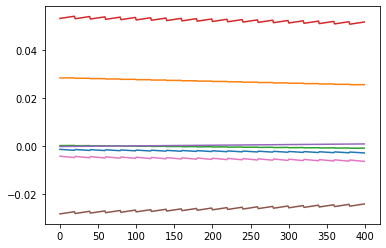

In [94]:
for i in range(7):
    plt.plot(actions_joints[:, i])

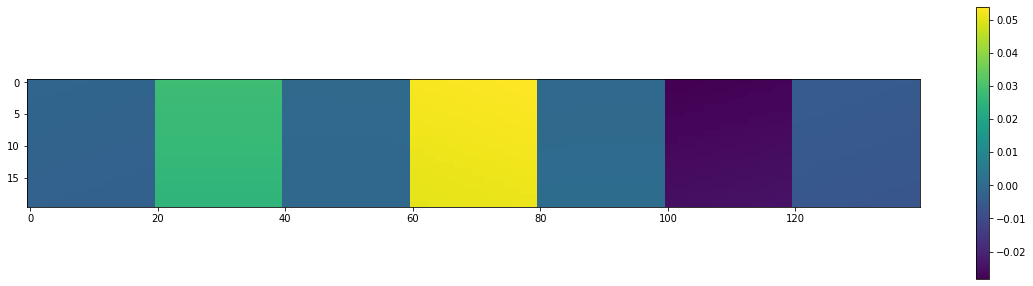

In [95]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [96]:
actions_joints.mean(axis=0)

array([-0.00216531,  0.02687841, -0.00037666,  0.05226462,  0.00030163,
       -0.02618209, -0.00533927], dtype=float32)

In [97]:
for param in decoder.decoder.named_parameters():
    print(param)

('0.weight', Parameter containing:
tensor([[-2.0087e-04, -5.8085e-04],
        [ 1.6034e-05, -1.4811e-03],
        [ 3.0280e-05, -5.8041e-04],
        [ 4.7794e-04, -1.2640e-03],
        [ 2.9898e-05,  5.3664e-04],
        [ 4.8642e-04,  1.6933e-03],
        [-3.0109e-04, -8.2957e-04]], requires_grad=True))
('0.bias', Parameter containing:
tensor([-0.0022,  0.0268, -0.0004,  0.0522,  0.0003, -0.0261, -0.0054],
       requires_grad=True))


In [98]:
next(VAE(action_dim=7, latent_dim=2, enc_dims=(2, ), dec_dims=(), lr=0, kl_coeff=0).decoder.parameters())

Parameter containing:
tensor([[ 0.5504,  0.3249],
        [ 0.4671,  0.1184],
        [-0.2878,  0.2339],
        [-0.0681,  0.1183],
        [-0.1874,  0.0309],
        [-0.2208,  0.0996],
        [ 0.6354, -0.4607]], requires_grad=True)

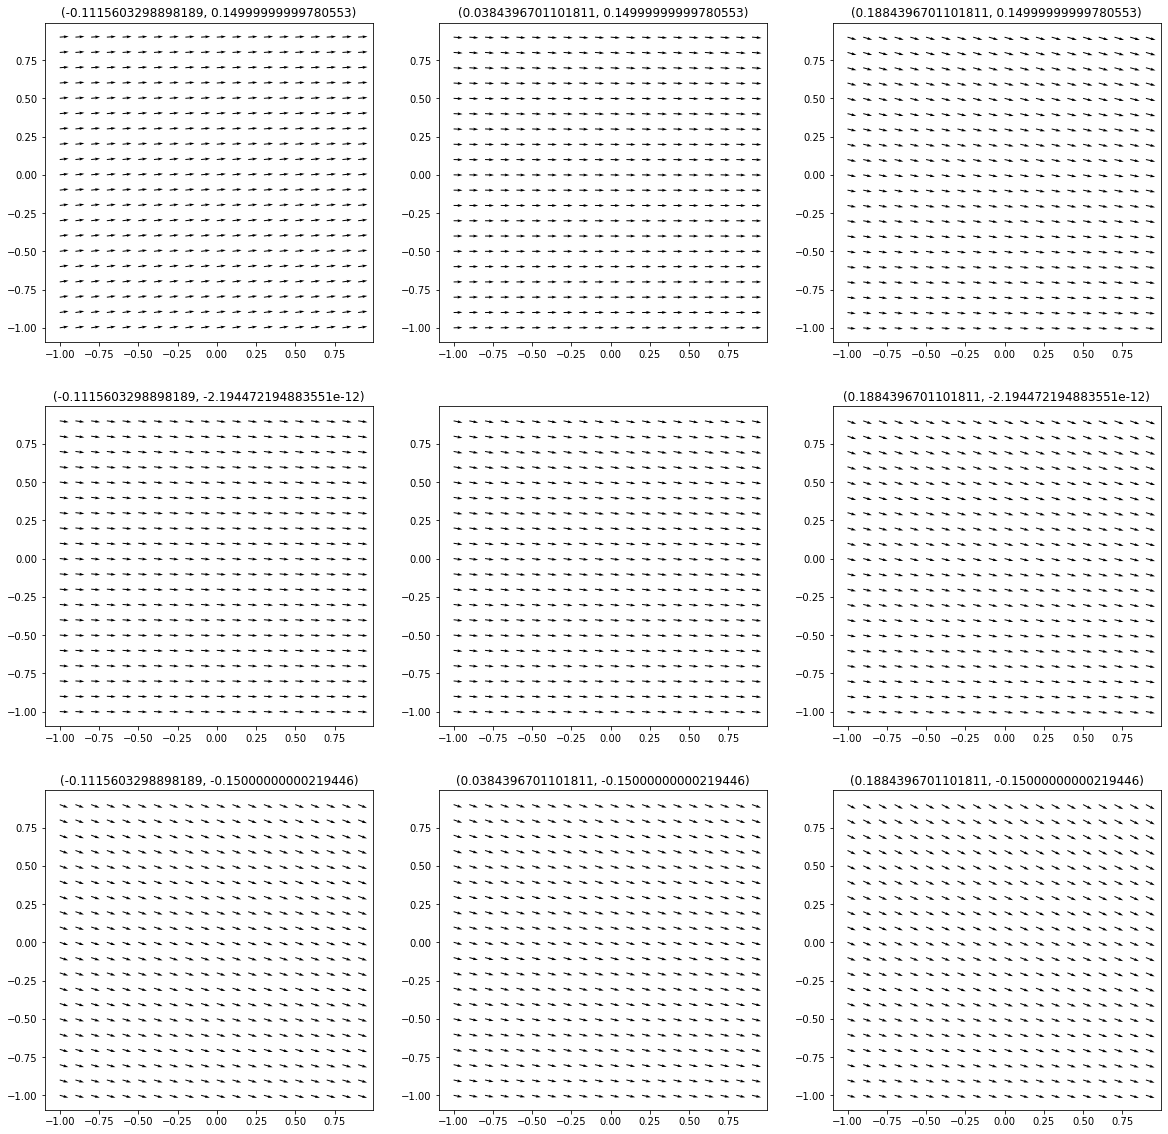

In [99]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

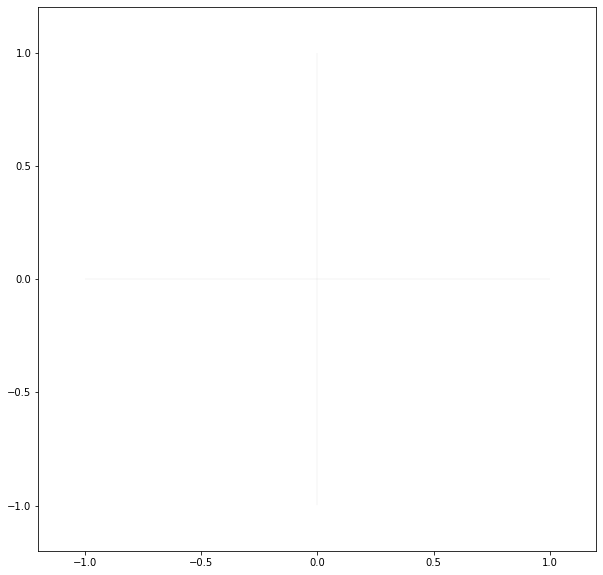

In [100]:
actions_joints_test = np.array([step['action_joints'] for epi in episodes for step in epi])[100000:101000]

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

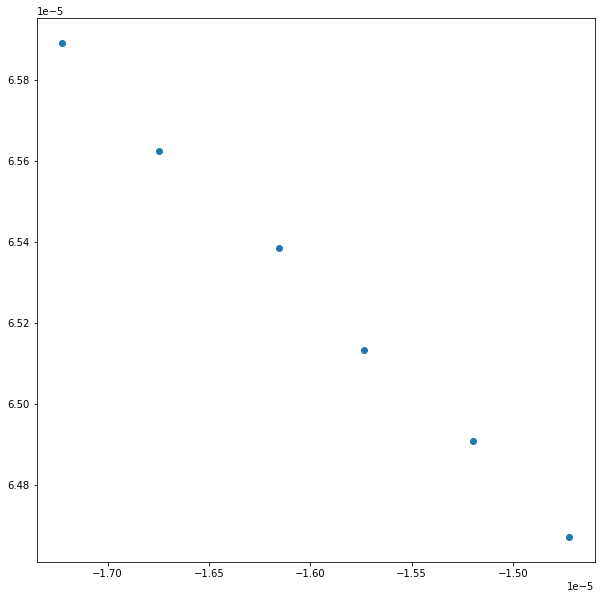

In [101]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

## worldly-blaze-406
Linear VAE, kl coeff = 0

In [102]:
decoder = VAE.load_from_checkpoint('latent-action/14e6eueq/checkpoints/epoch=399-step=999999.ckpt')

In [103]:
decoder

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=7, bias=True)
  )
  (fc_mu): Linear(in_features=2, out_features=2, bias=True)
  (fc_var): Linear(in_features=2, out_features=2, bias=True)
)

In [104]:
x, y = np.meshgrid(np.arange(-3.5, 0.5, 0.2), np.arange(-1, 4, 0.2))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

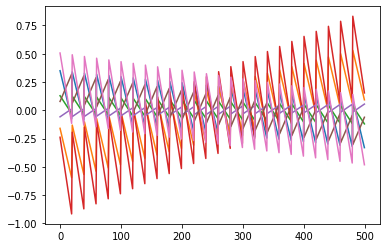

In [105]:
for i in range(7):
    plt.plot(actions_joints[:, i])

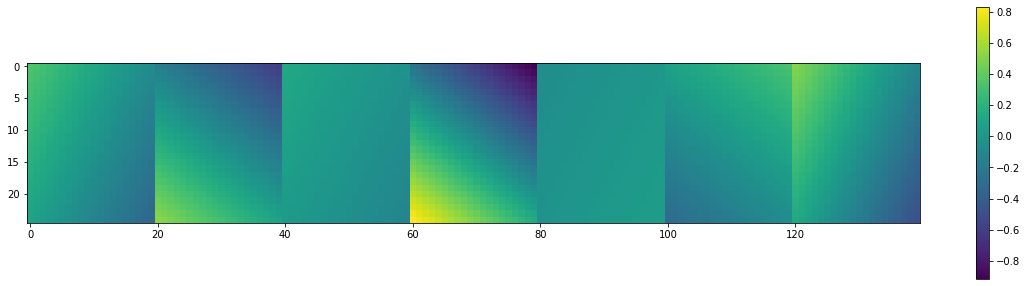

In [106]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(25, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

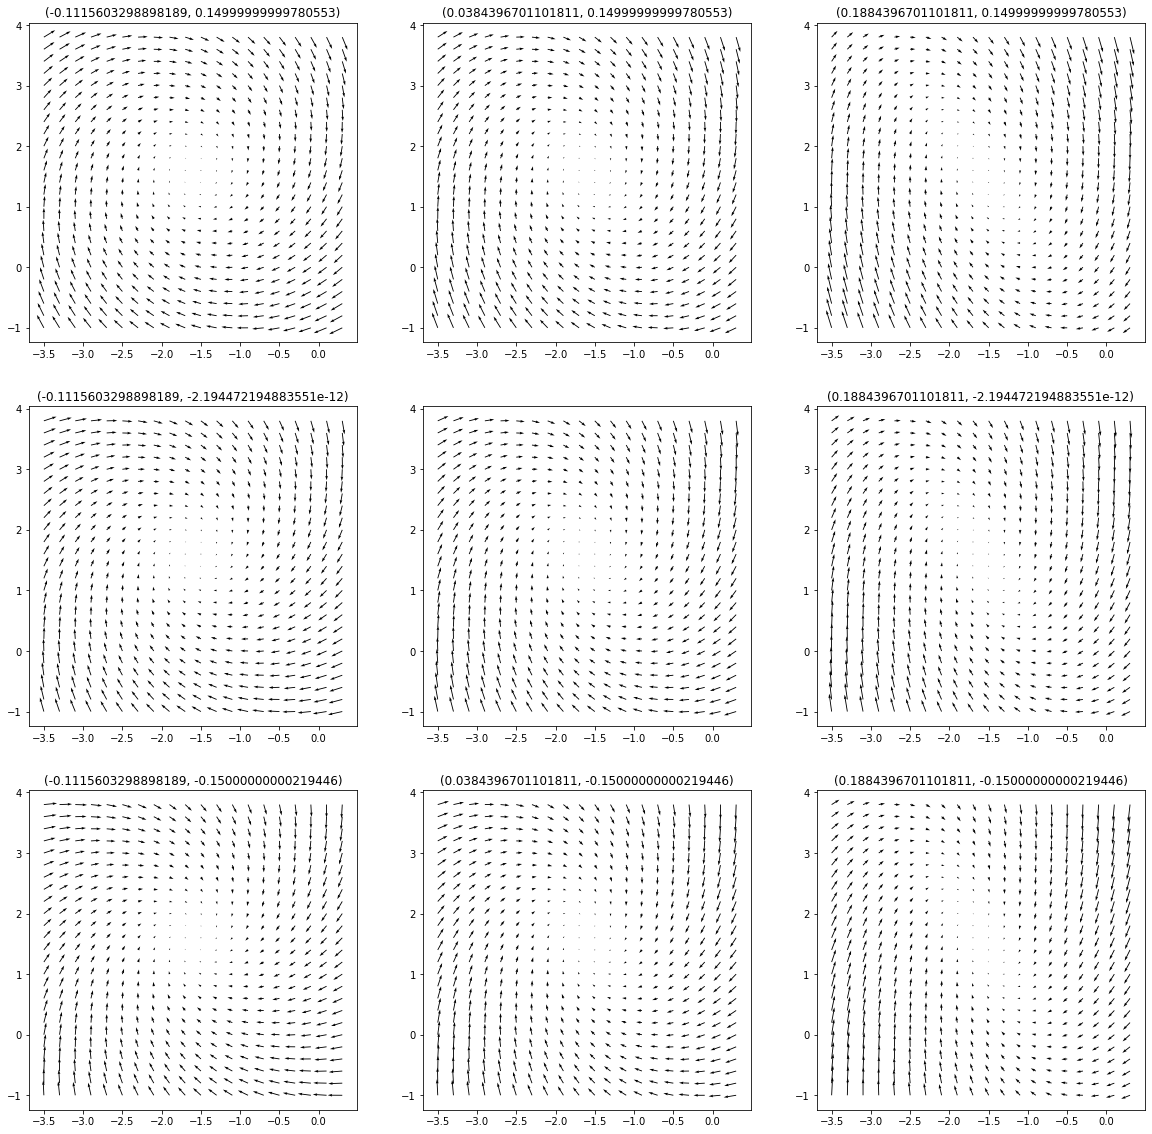

In [107]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

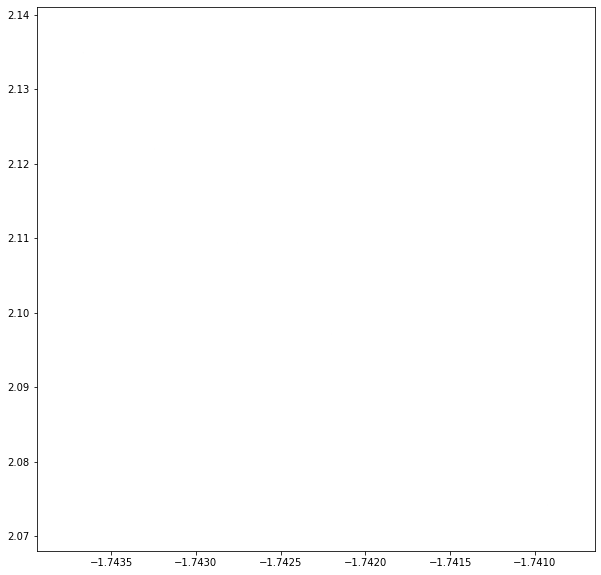

In [108]:
actions_joints_test = np.array([step['action_joints'] for epi in episodes for step in epi])[100000:101000]

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

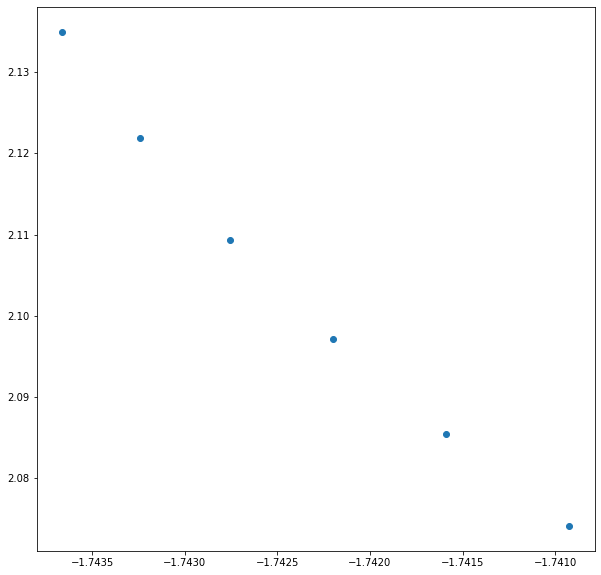

In [109]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

## desert-sound-410
Linear VAE, kl coeff = 0.01

In [110]:
decoder = VAE.load_from_checkpoint('latent-action/bqngf25n/checkpoints/epoch=399-step=999999.ckpt')

In [111]:
x, y = np.meshgrid(np.arange(-2, 2, 0.2), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

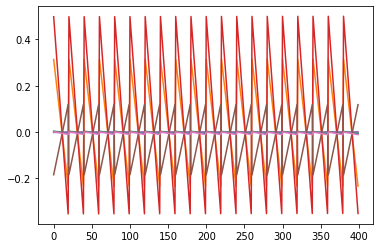

In [112]:
for i in range(7):
    plt.plot(actions_joints[:, i])

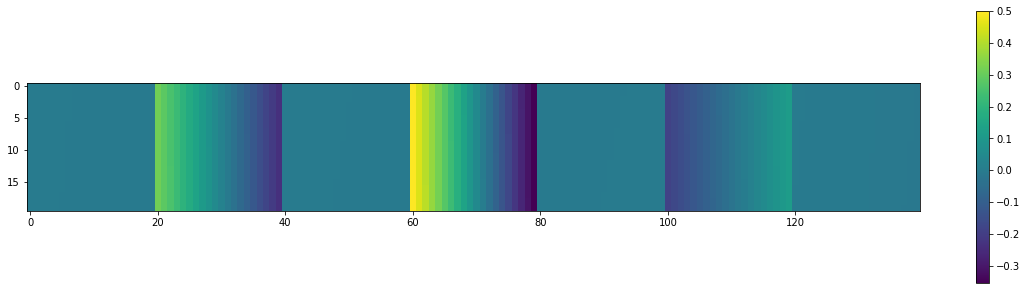

In [113]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [114]:
actions_joints.mean(axis=0)

array([-0.00160337,  0.04003198, -0.00021919,  0.07335015, -0.00027253,
       -0.03296629, -0.00514061], dtype=float32)

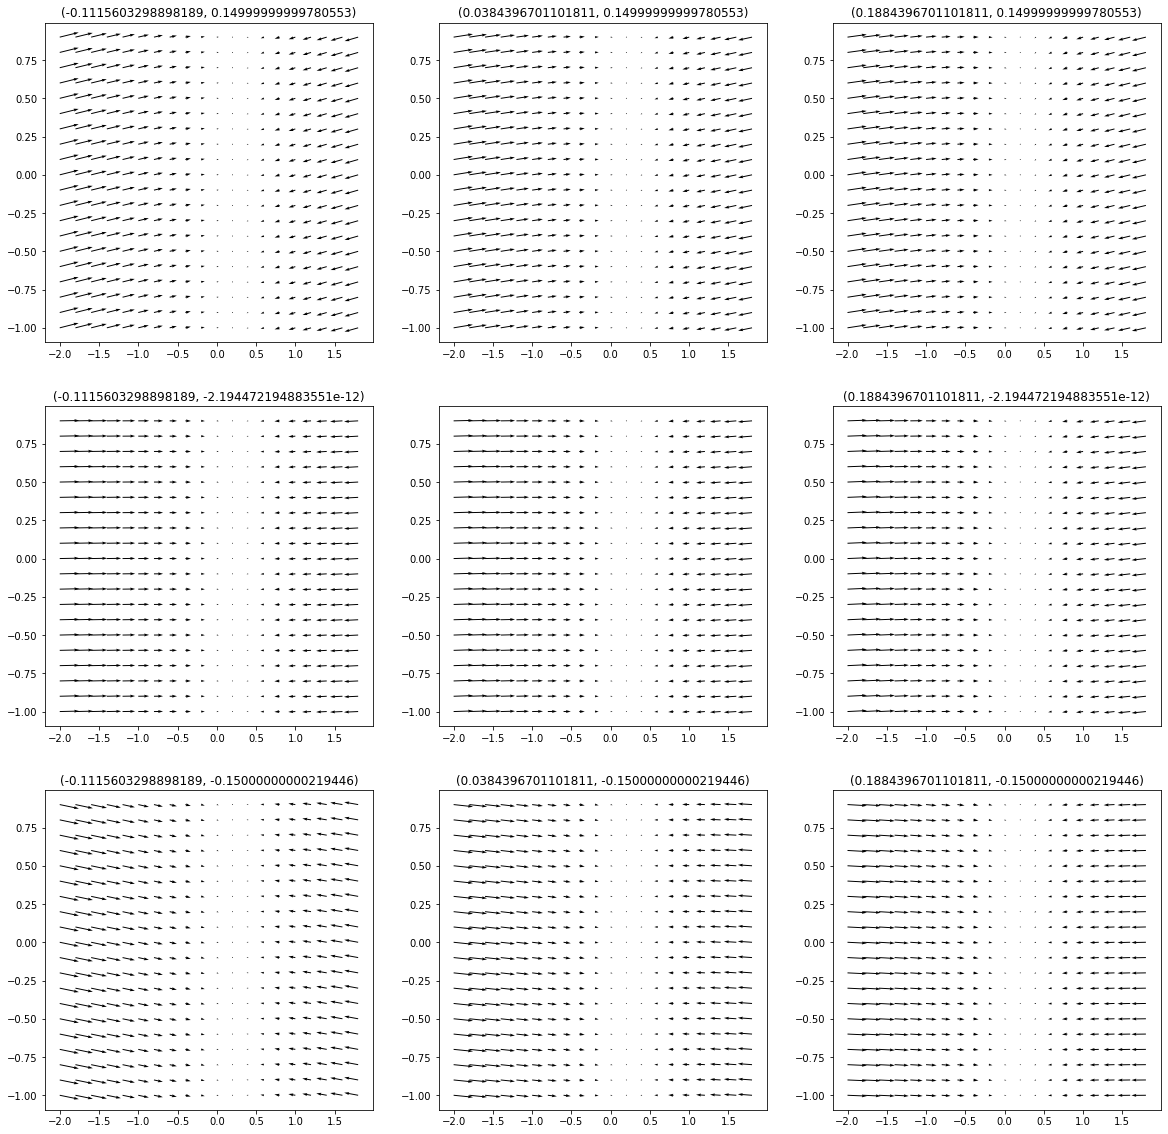

In [115]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

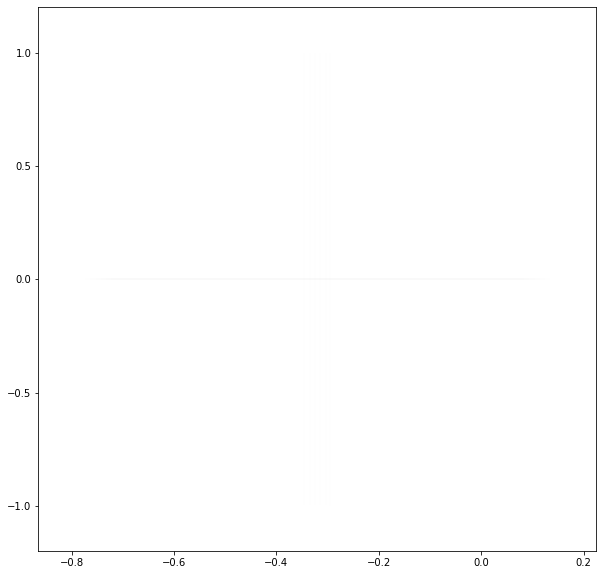

In [116]:
actions_joints_test = np.array([step['action_joints'] for epi in episodes for step in epi])[100000:101000]

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

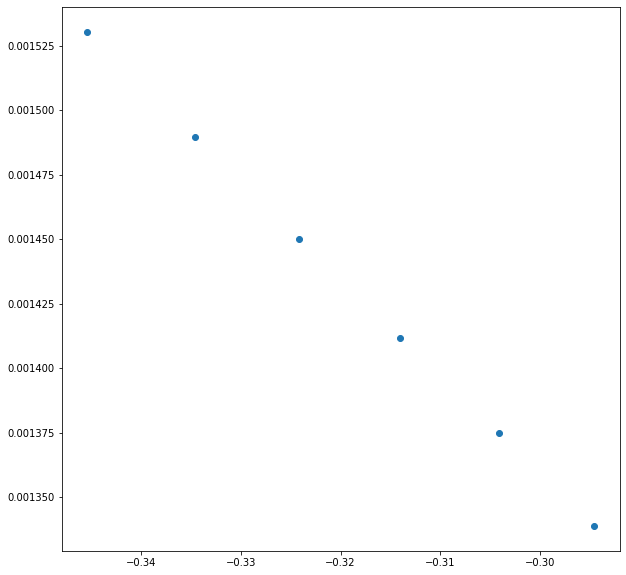

In [117]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()

## swift-waterfall-409
Linear VAE, kl coeff = 0.1

In [118]:
decoder = VAE.load_from_checkpoint('latent-action/189voeag/checkpoints/epoch=399-step=999999.ckpt')

In [119]:
x, y = np.meshgrid(np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1))
latents = torch.tensor(list(zip(x.reshape(-1), y.reshape(-1))), dtype=torch.float)
actions_joints = decoder(latent=latents, context=None).detach().numpy()

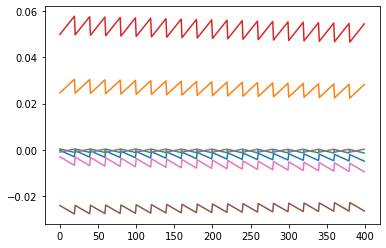

In [120]:
for i in range(7):
    plt.plot(actions_joints[:, i])

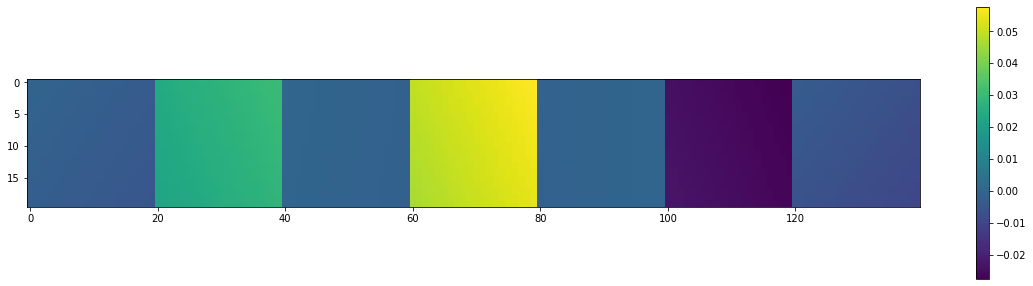

In [121]:
fig = plt.figure(figsize=(20, 5))
plt.imshow(np.concatenate([actions_joints[:, i].reshape(20, 20) for i in range(7)], axis=1))
plt.colorbar()
plt.show()

In [122]:
actions_joints.mean(axis=0)

array([-0.00247877,  0.02639293, -0.00042913,  0.05205061, -0.00028125,
       -0.02509465, -0.0061627 ], dtype=float32)

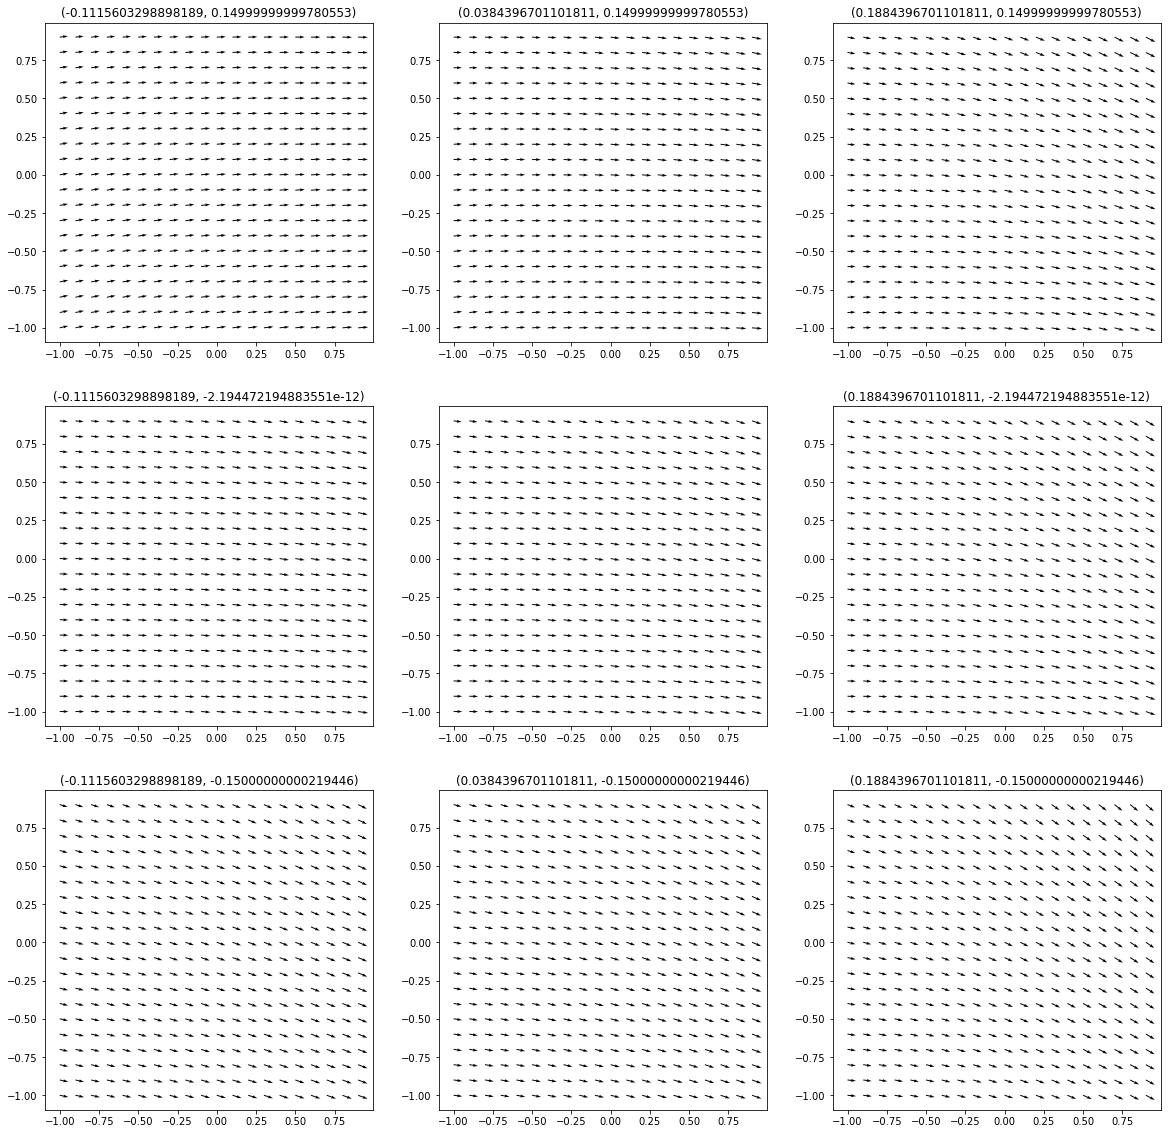

In [123]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i, (goal, joint_angles) in enumerate(zip(goals, joint_angles_at_goals)):
    if i >= 4:
        i += 1 # offset for visualization

    actions_ee = []
    env.robot.set_joint_angles(joint_angles)
    current_ee_position = env._get_obs()['achieved_goal']
    
    for action_joints in actions_joints:
        obs, _, _, _ = env.step(action_joints)
        actions_ee.append(obs['achieved_goal'] - current_ee_position)
        env.robot.set_joint_angles(joint_angles)

    actions_ee = np.array(actions_ee)
    axs[i // 3, i % 3].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])
    axs[i // 3, i % 3].set_title(goal[:2])
    
actions_ee = []
env.reset()

for action_joints in actions_joints:
    obs, _, _, _ = env.step(action_joints)
    actions_ee.append(obs['achieved_goal'] - neutral_ee_position)
    env.reset()

actions_ee = np.array(actions_ee)
axs[1, 1].quiver(x, y, actions_ee[:, 0], actions_ee[:, 1])

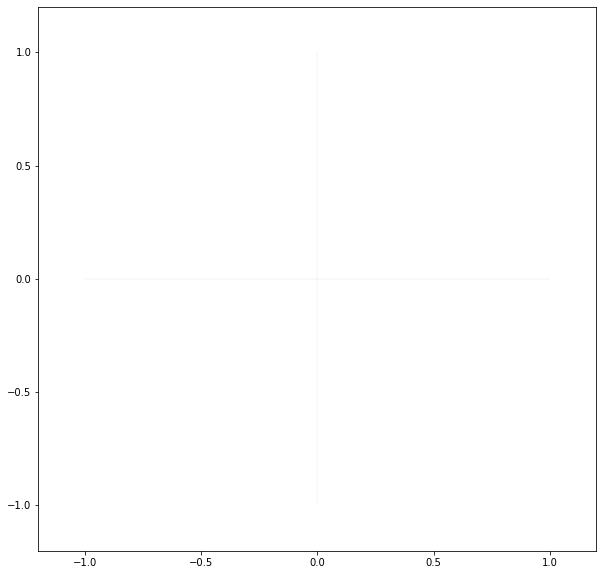

In [124]:
actions_joints_test = np.array([step['action_joints'] for epi in episodes for step in epi])[100000:101000]

x = decoder.encoder(torch.tensor(actions_joints_test, dtype=torch.float))
mu = decoder.fc_mu(x).detach().numpy()
log_var = decoder.fc_var(x)
std = torch.exp(log_var / 2).detach().numpy()

std_x = std.copy()
std_x[:, 1] = 0
std_y = std.copy()
std_y[:, 0] = 0

horizontal_lines = np.array(list(zip(mu-std_x, mu+std_x)))
vertical_lines = list(zip(mu-std_y, mu+std_y))

hlc = mc.LineCollection(horizontal_lines, linewidths=0.01)
vlc = mc.LineCollection(vertical_lines, linewidths=0.01)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(hlc)
ax.add_collection(vlc)
ax.autoscale()
ax.margins(0.1)

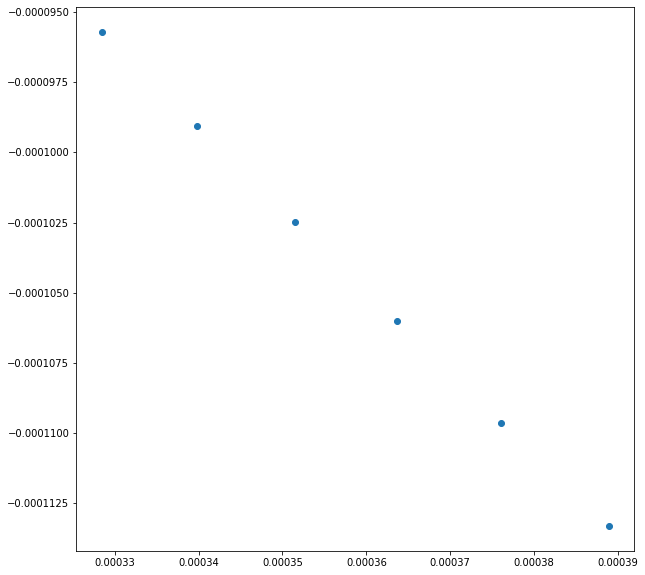

In [125]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1])
plt.show()